# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [494]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [495]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [496]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [497]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


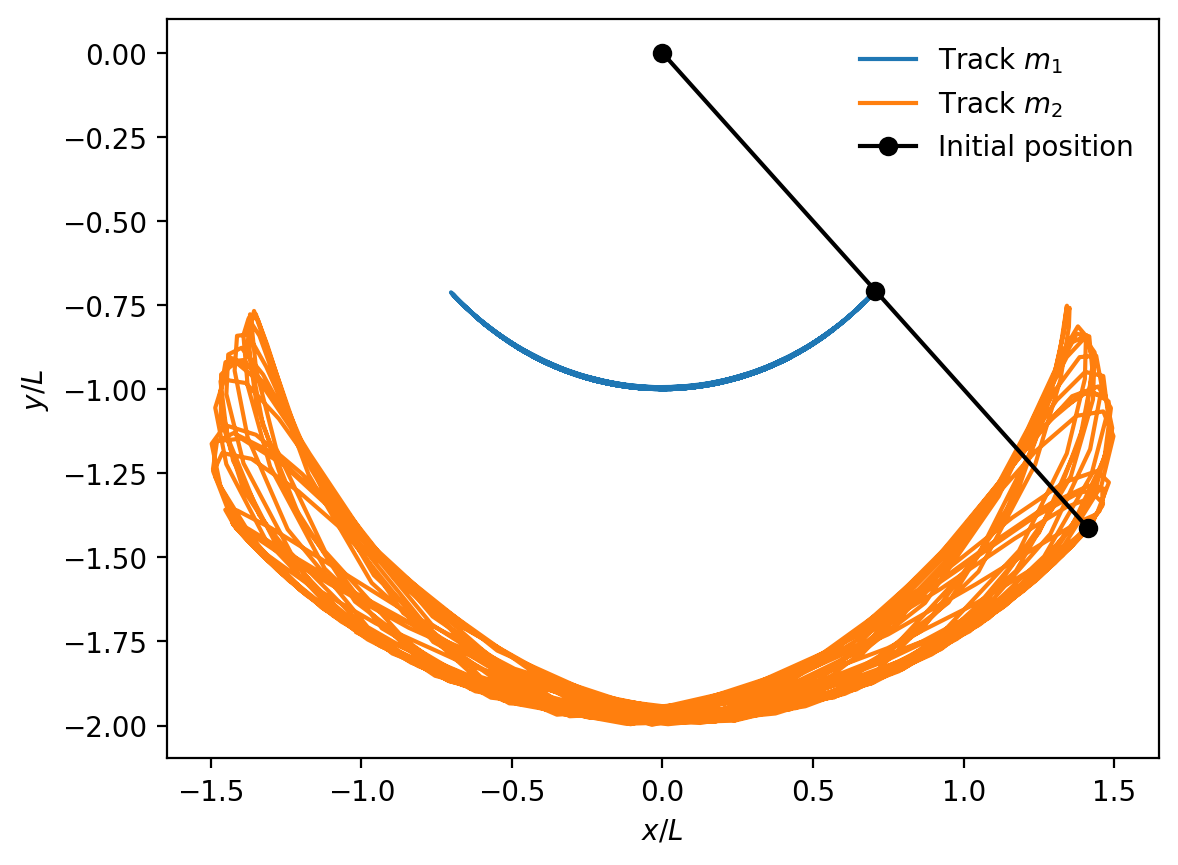

In [498]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



. </br>
. </br>
. </br>
. </br>
. </br>
. </br>
. </br>
. </br>
. </br>
. </br>
__________________________________________________
#                                         And so my code begins...
. </br>
. </br>
. </br>
. </br>

#### Code guides are written in this format.
>**Comments and conclusions are written in this format,** 

#### First, let's import everything that I need that isn't in the previous importing cell.

In [499]:
#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

_________
## 1. Designing and Training a Recurrent Neural Network to predict the future!
#### Or rather, the future positions of the double-pendulum. Future is defined as $t=t_0 + 20 \delta t$. Initial conditions are set to $z_0=[\pi/4,0,\pi/4,0]$. 


#### Generating the RNN

In [500]:
                                  ##Generating a Recurrence Neural Network##
model=keras.models.Sequential()


model.add(keras.layers.LSTM(50,input_shape=(None, 4)))       #LSTM layer with 50 neurons. 
                                                             #Input shape is 4 for each x1,x2,y1 and y2


model.add(keras.layers.Flatten())                            #from sequential to flat NN:

model.add(keras.layers.Dense(265, activation='relu'))        #add hidden layer
model.add(keras.layers.Dense(192, activation='relu'))        #add hidden layer

model.add(keras.layers.Dense(4, activation='linear'))        #output layer with 4 nueron for each x1, x2, y1 or y2

model.compile(loss='mean_squared_error',optimizer='adam')    #Compile the model with 'adam' optimizer being used.
model.summary()                                              #Print a summary of the NN

Model: "sequential_457"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_457 (LSTM)             (None, 50)                11000     
                                                                 
 flatten_457 (Flatten)       (None, 50)                0         
                                                                 
 dense_1371 (Dense)          (None, 265)               13515     
                                                                 
 dense_1372 (Dense)          (None, 192)               51072     
                                                                 
 dense_1373 (Dense)          (None, 4)                 772       
                                                                 
Total params: 76,359
Trainable params: 76,359
Non-trainable params: 0
_________________________________________________________________


#### Creating the testing and training data.</br>

Here, we take a segemnt of data from x1 or y1  or x2 or y2 and store it as an array. Then, we move the segment's position in the dataset by 1 step and store this new segment in another array.</br>

Here's an example:</br>
>x1 = 1,2,3,4,5,6,**7,8,9,10,11,121,3,14,15,16,17,18**,19,20,21,23,24,25,26,27,28,29,30

Here, the window-size is 12
Now, if we set segment 1 as the highlighted area, then:
>seg1 = 7,8,9,10,11,121,3,14,15,16,17,18

But now, if we move the segment by one step:
>x1 = 1,2,3,4,5,6,7,**8,9,10,11,121,3,14,15,16,17,18,19**,20,21,23,24,25,26,27,28,29,30

Then, seg2 is:
>seg2 = 8,9,10,11,121,3,14,15,16,17,18,19

Thus, the new training dataset will then have segN-arrays in it, with N=len(x1). 
>Training_set = [  [seg1]
                 [seg2]
                 .
                 .
                 [segN]  ]

In [501]:
#We train the RNN over a limited range of the y data and x data and test it over the full range:

#Doing this for y-dataset.
y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]


#stack each x1,y1,x2 or y2 test(or train) data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

#####################################################################################################
                    ##Now we create the training and testing dataset for the RNN##
def create_dataset(dataset,offset, windowsize):
    '''INPUTS:
    dataset: the 4-row array of x1,y1,x2 and y2 for either training or test
    offset: how many samples into the future to predict
    windowsize: Length of the segment of data we are using.
    OUTPUTS:
    input_data: tuple of dataset for input into RNN
    label_data: tuple of dataset for target of RNN
    '''
    
    input_data, label_data = [], [] 
    #looping over the dataset
    for i in range(windowsize, len(dataset[0]) - offset):
        a = dataset[:,(i-windowsize):i] #
        
        input_data.append(a)
        label_data.append(dataset[:,i+offset])  
       
        
    input_data, label_data = np.array(input_data), np.array(label_data)
    return  input_data, label_data

windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


#trainng and test dataset(inp=input and tgt=target for NN):
train_inp, train_tgt = create_dataset(train_data,offset, windowsize)
test_inp, test_tgt = create_dataset(test_data,offset, windowsize)


#shapes:
print("The shape of the test data is",test_data.shape, "where the 4 rows are x1_test, y1_test, x2_test and y2_test")
print("The shape of the training data is",test_data.shape, "where the 4 rows are x1_train, y1_train, x2_train, y2_train")
print()
print("The shape of the training input data is",train_inp.shape)
print("The shape of the training label data is",train_tgt.shape)
print()
print("The shape of the test input data is",test_inp.shape)
print("The shape of the test label data is",test_tgt.shape)

The shape of the test data is (4, 200) where the 4 rows are x1_test, y1_test, x2_test and y2_test
The shape of the training data is (4, 200) where the 4 rows are x1_train, y1_train, x2_train, y2_train

The shape of the training input data is (250, 4, 30)
The shape of the training label data is (250, 4)

The shape of the test input data is (150, 4, 30)
The shape of the test label data is (150, 4)


In [502]:
steps=1000  #Number of training steps
costs=np.zeros(steps) #empty array for cost along each step


for i in tqdm(range(steps)):
    
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_tgt.reshape(train_tgt.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    
    #Train the network and store to 'costs' empty array so that we can look at change in cost over steps.
    costs[i]=model.train_on_batch(in_train, targ_train)

100%|██████████| 1000/1000 [00:42<00:00, 23.67it/s]


#### Let's check how the cost varies with each step

0.0006518264999613166

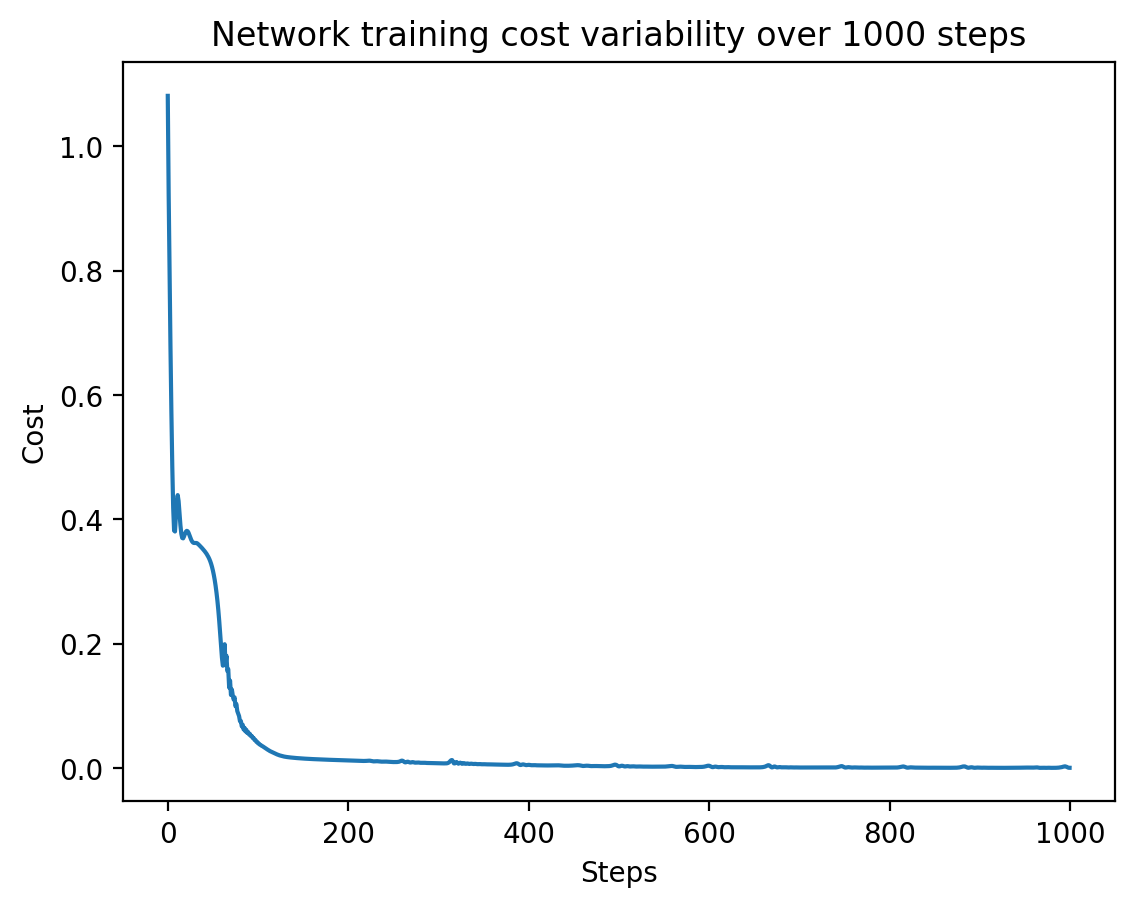

In [503]:
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network training cost variability over 1000 steps")
costs[-1]

Let's look at the near-linear portion of that graph

0.0006518264999613166

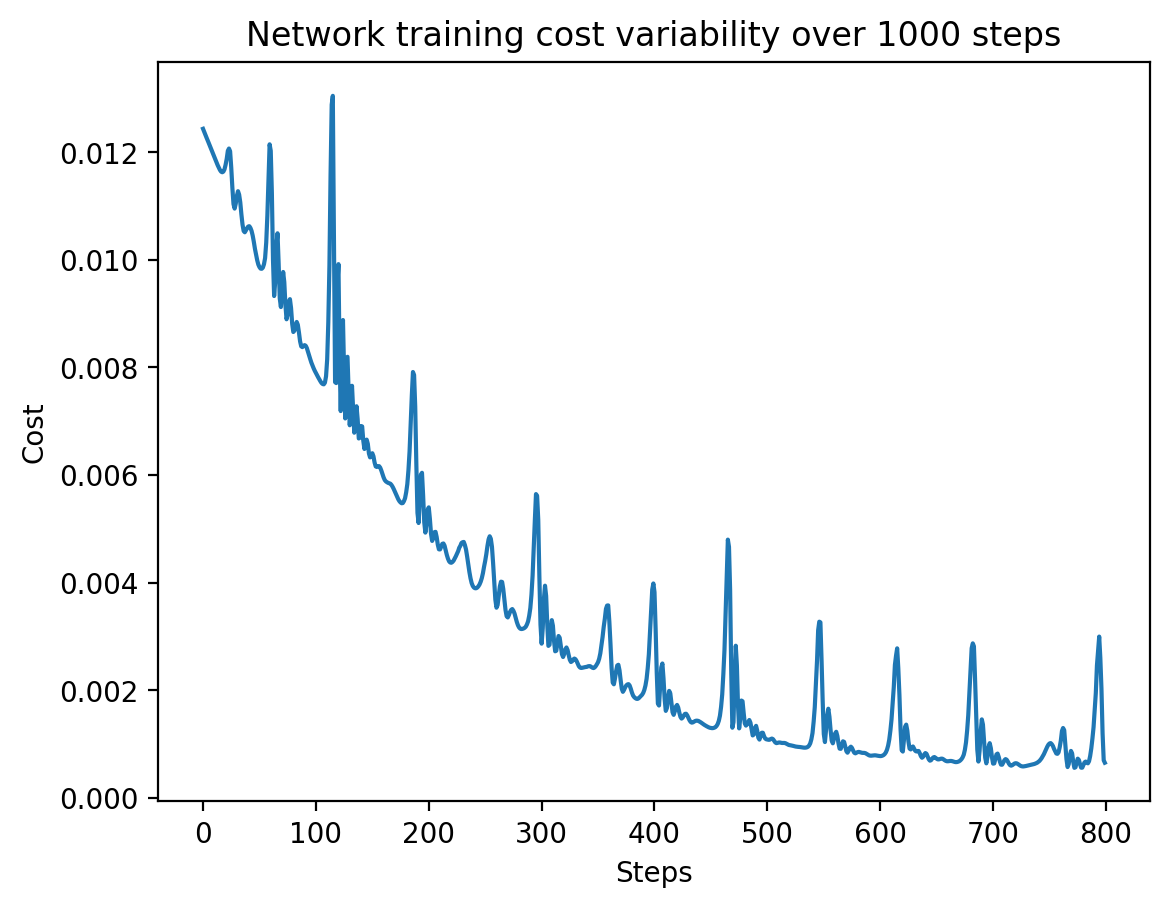

In [504]:
fig,ax=plt.subplots()
ax.plot(np.arange(steps-200),costs[200:],label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network training cost variability over 1000 steps")
costs[-1]

>**The final cost we get is about 0.0008, which is pretty good. The cost seems to stabilize to pretty low level at about 100 steps, after which ther are diminishing returns. It is interesting to see that there seem to be spikes in the cost every 50-150 steps.**

#### Now, let's check accuracy of our model's predictions

In [505]:
#Reshaping the test input data for the same reasons we did for the training input data before training the RNN
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)


test=model.predict_on_batch(in_test) #gives output from RNN
print(test.shape)
print(test_lbl.shape) #lbl = target

(150, 4)
(70, 4)


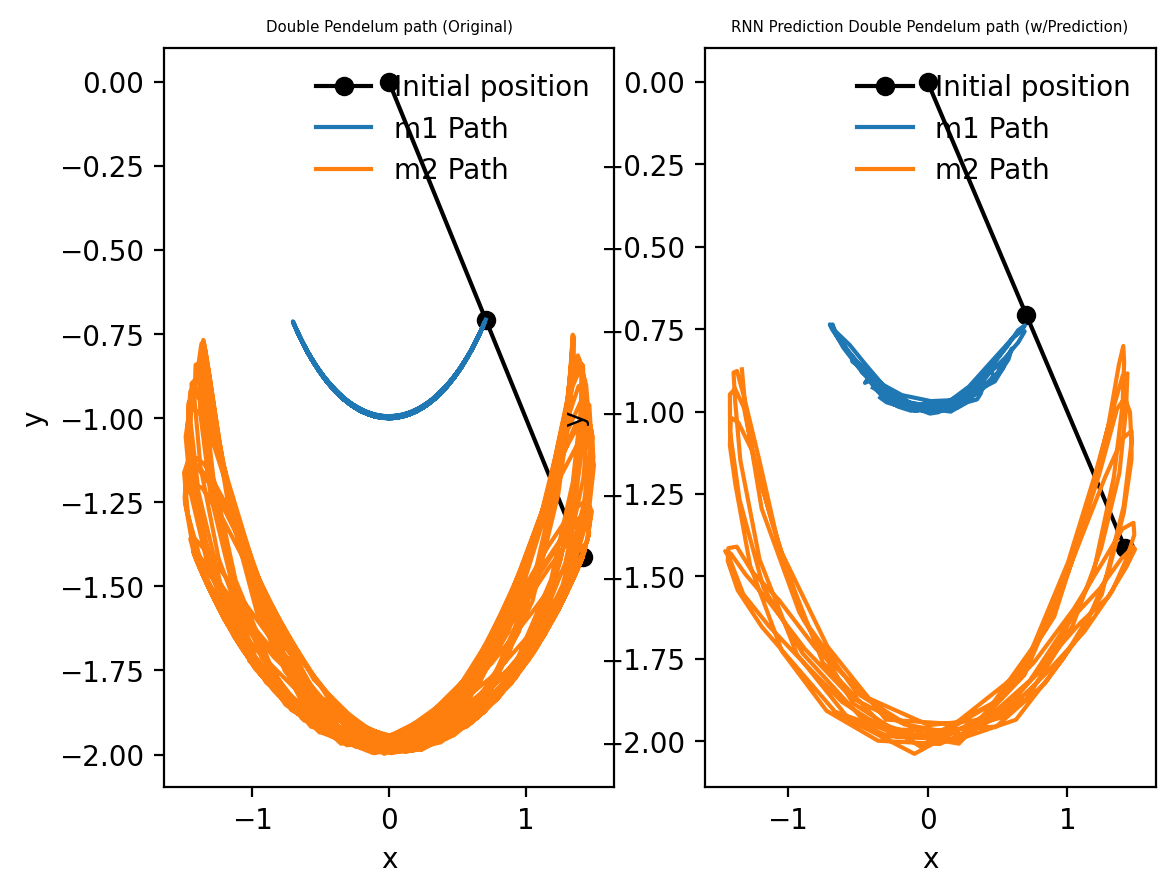

In [506]:
fig,ax=plt.subplots(nrows=1, ncols=2, )

#Plot for original double-pendulum movement:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path (Original)", size=5.4)
ax[0].legend()

#Plot of double-pendulum from prediction of RNN:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path (w/Prediction)", size=5.4)
ax[1].legend()



>**Although the RNN does really well on predicting the more-chaotic movements of the the second pendulum, it does a comparitively bad job of predicting the movement of the first pendulum. This might be due to the code generating a baseline randomness to the prediction which is well approximated by the randomness in the second pendulum's movement.**

_________
## 2. Checking the stability of my network to variations in inital conditions.
#### This will be done by making a plot of x and y .vs. time to show the network prediction in comparison to the solution from solve_ivp.
#### I will be varying the initial conditions and looking at how close the predictions are to the original.

In [507]:
##Lets define a function that outputs the plots of the varied initial conditions.
def variation_checker(i,j,model=model):
    '''
    Takes in i&j as variables that affect the initial conditions of the double pendulum and generates a plot of the double
    pendulum's movement and a plot of the RNN's prediction of said movement.
    
    Inputs:
      -i should realistically be between 0 and 1 as is the denominator to pi. Used to generate theta1 & theta2.
      -j can be any value. Used to generate w1 and w2
      -model which is being used to generate the predictions. Defaults to the model for Part 1.
      
    Outputs:
      -Generates the plots of Double pendulum and RNN's prediction of it.
      -Returns the values of x1, x2, y1, y2 which should be stored in that order and naming scheme to further use the t-xy 
       function.
    '''
                          #########################################################
                          ##Changing the initial conditions and running rhs again##
                          #########################################################
        
    #Starting angles
    z0=[np.pi/i,j,np.pi/i,j]    #Changes depending on the value of 'i' input.

    #Time ranges
    tmax, dt = 50, 0.1
    t = np.arange(0, tmax+dt, dt)

    # Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y
    print(np.shape(z))

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    
                        ###############################################################
                        ##Creating the training and testing datasets (same as before)##
                        ###############################################################
    
    #Doing this for y-dataset.
    y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
    y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
    y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
    y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


    #And now the same as above, but for x
    x1_train=x1[0:int(0.6*len(x1))] 
    x2_train=x2[0:int(0.6*len(x2))] 
    x1_test=x1[int(0.6*len(x1)):-1]
    x2_test=x2[int(0.6*len(x2)):-1]

    #stack each x1,y1,x2 or y2 test(or train) data on top of each other in an array:
    test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
    train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

    windowsize=30 #Number of samples we will use to train our network
    offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


    #trainng and test dataset(inp=input and tgt=target for NN):
    train_inp, train_tgt = create_dataset(train_data,offset, windowsize)
    test_inp, test_tgt = create_dataset(test_data,offset, windowsize)


    #shapes:
    #print("The shape of the test data is",test_data.shape, "where the 4 rows are x1_test, y1_test, x2_test and y2_test")
    #print("The shape of the training data is",test_data.shape, "where the 4 rows are x1_train, y1_train, x2_train, y2_train")
    #print()
    #print("The shape of the training input data is",train_inp.shape)
    #print("The shape of the training label data is",train_tgt.shape)
    #print()
    #print("The shape of the test input data is",test_inp.shape)
    #print("The shape of the test label data is",test_tgt.shape)
    
                                    ########################################
                                    ##Testing and plotting the predictions##
                                    ########################################
    
    #Test w new test data:
    #we first have to reshape the test input data for the same reasons we did for the training input data
    in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    test=model.predict_on_batch(in_test) #gives output from RNN    


    fig,ax=plt.subplots(nrows=1, ncols=2, )

    #rhs method plot:
    ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
    ax[0].plot(x1,y1,label="m1 Path")
    ax[0].plot(x2,y2,label="m2 Path")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].set_title(f"Double pendulum path", size=5.4)
    ax[0].legend()

    #RNN method plot:
    ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
    ax[1].plot(test[:,0], test[:,1],label="m1 Path")
    ax[1].plot(test[:,2], test[:,3],label="m2 Path")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")
    ax[1].set_title(f"RNN Prediction Double Pendulum path", size=5.4)
    ax[1].legend()


    fig.tight_layout()
    
    return x1,x2,y1,y2   #This is to be stored in variables of the same name to then be used to generate the t-xy plot. 

#### For initial conditions: $z_0=[\pi/2,0,\pi/2,0]$

(4, 501)


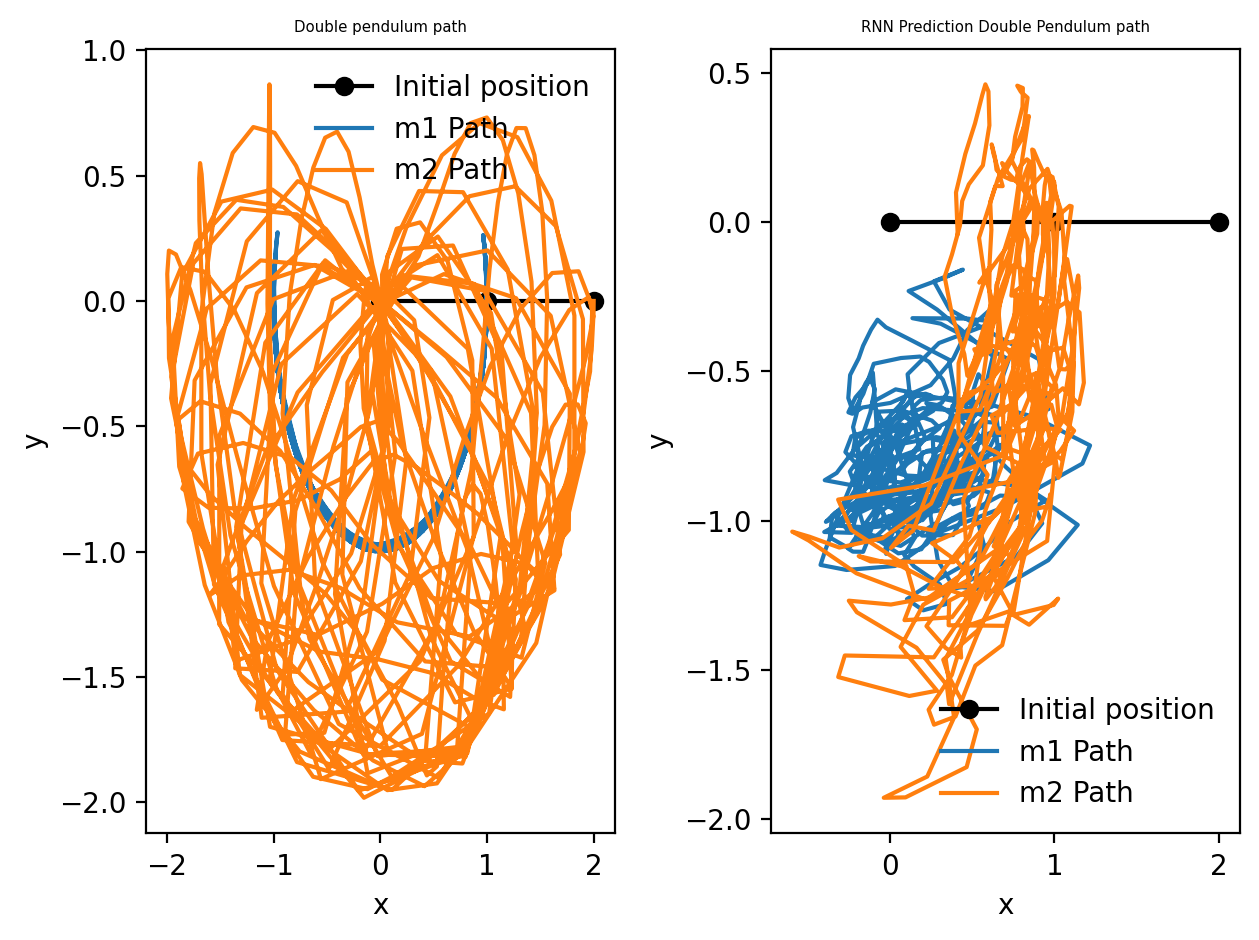

In [508]:
x1,x2,y1,y2 = variation_checker(i=2,j=0)

#### Plotting x and y .vs. time

In [509]:
    
def txy_plotter():    
    fig,ax=plt.subplots(nrows=2, ncols=2, )

    #m1_x:
    ax[0,0].plot(t,x1,label="Actual x1")
    ax[0,0].plot(t[:len(test[:,0])],test[:,0],label="Prediction x1")
    ax[0,0].set_xlabel("t")
    ax[0,0].set_ylabel("x")
    ax[0,0].set_title("Double Pendulum x path through time for m1", size=6)
    ax[0,0].legend(prop={'size':5})

    #m2_x:
    ax[0,1].plot(t,x2,label="Actual x1")
    ax[0,1].plot(t[:len(test[:,2])],test[:,2],label="Prediction x1")
    ax[0,1].set_xlabel("t")
    ax[0,1].set_ylabel("x")
    ax[0,1].set_title("Double Pendulum x path through time for m2", size=6)
    ax[0,1].legend(prop={'size':5})

    #m1_y:
    ax[1,0].plot(t,y1,label="Actual x1")
    ax[1,0].plot(t[:len(test[:,1])],test[:,1],label="Prediction x1")
    ax[1,0].set_xlabel("t")
    ax[1,0].set_ylabel("y")
    ax[1,0].set_title("Double Pendulum y path through time for m1", size=6)
    ax[1,0].legend(prop={'size':5})

    #m2_y:
    ax[1,1].plot(t,y2,label="Actual x1")
    ax[1,1].plot(t[:len(test[:,3])],test[:,3],label="Prediction x1")
    ax[1,1].set_xlabel("t")
    ax[1,1].set_ylabel("y")
    ax[1,1].set_title("Double Pendulum y path through time for m2", size=6)
    ax[1,1].legend(prop={'size':5})
    
    plt.subplots_adjust(
                    wspace=0.3, hspace=0.5)  #Adjust the space between the subplots to make it organized.

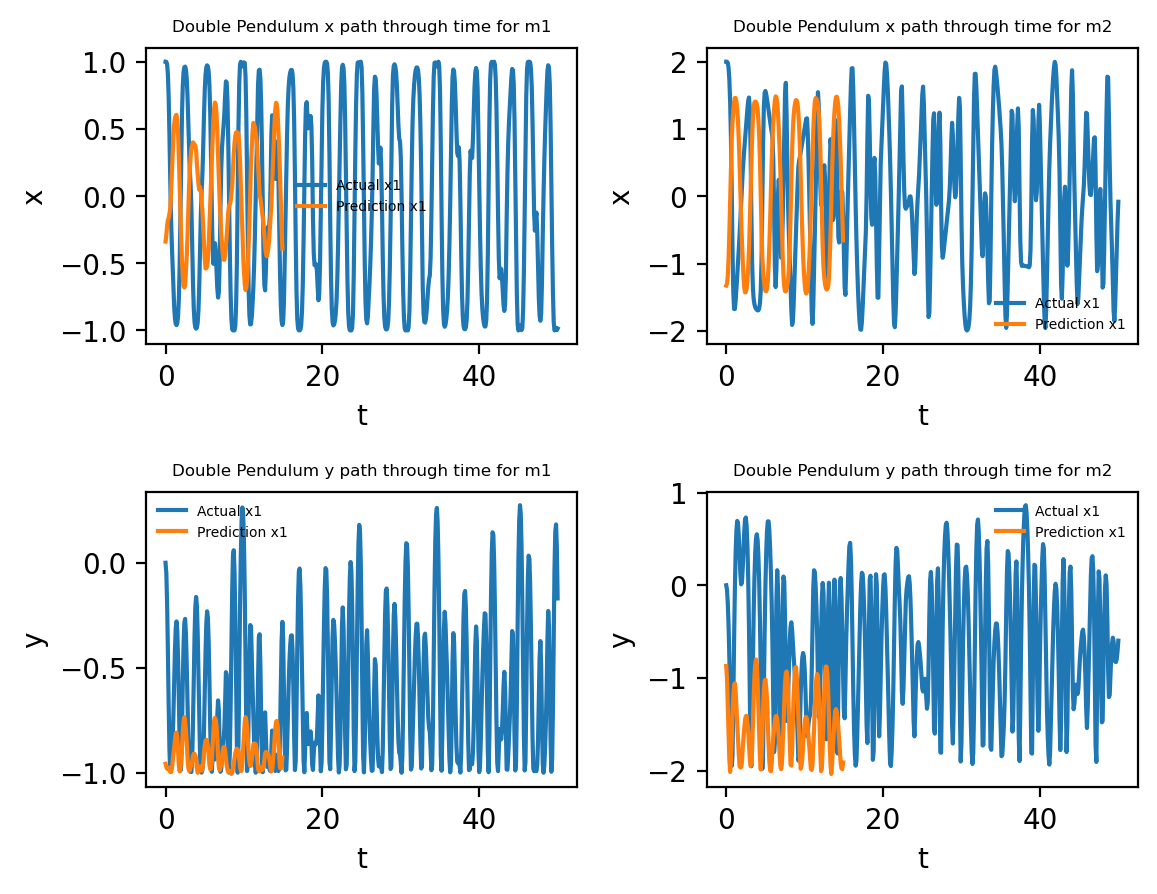

In [510]:
txy_plotter()

#### For initial conditions: $z_0=[\pi/4,3,\pi/4,3]$

(4, 501)


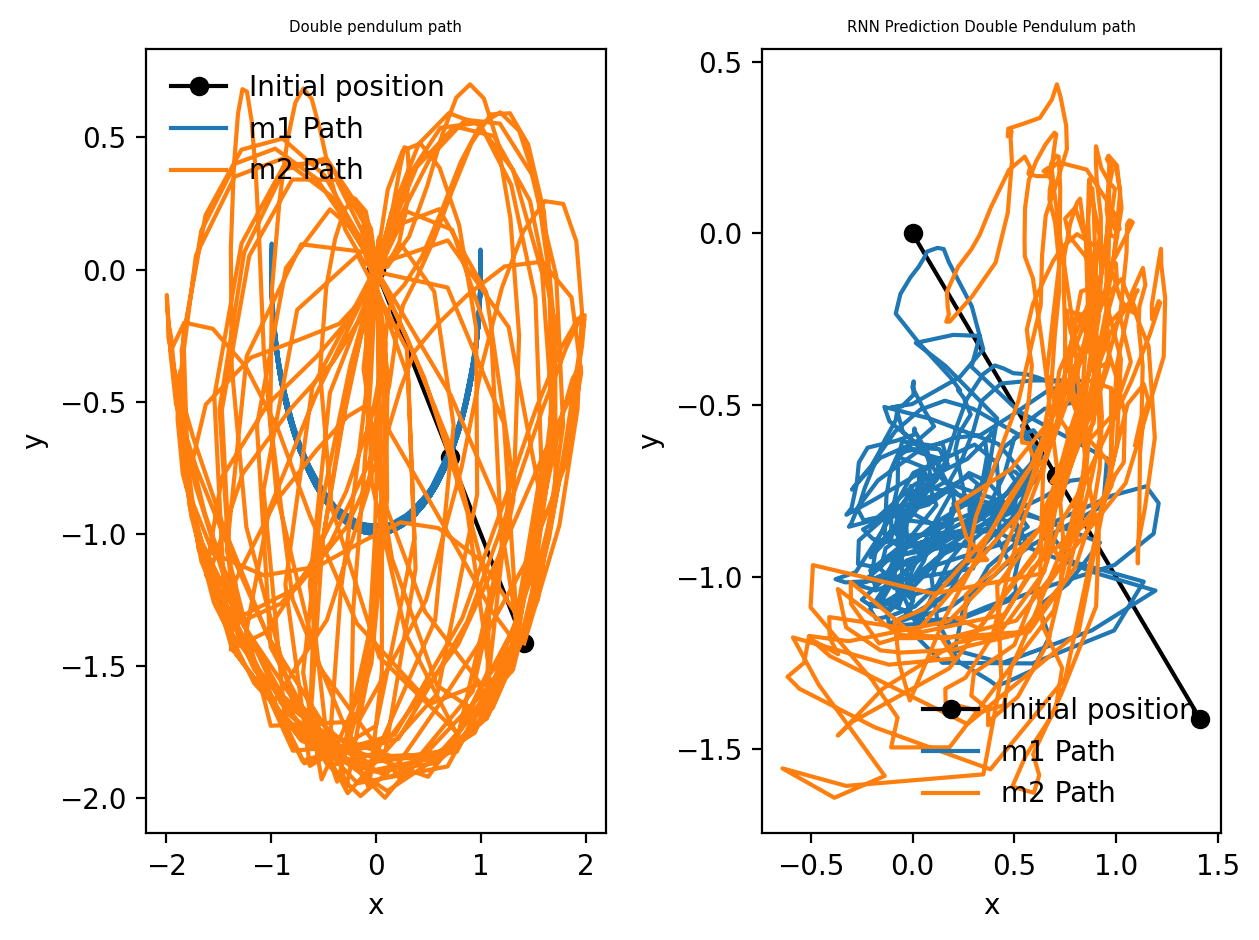

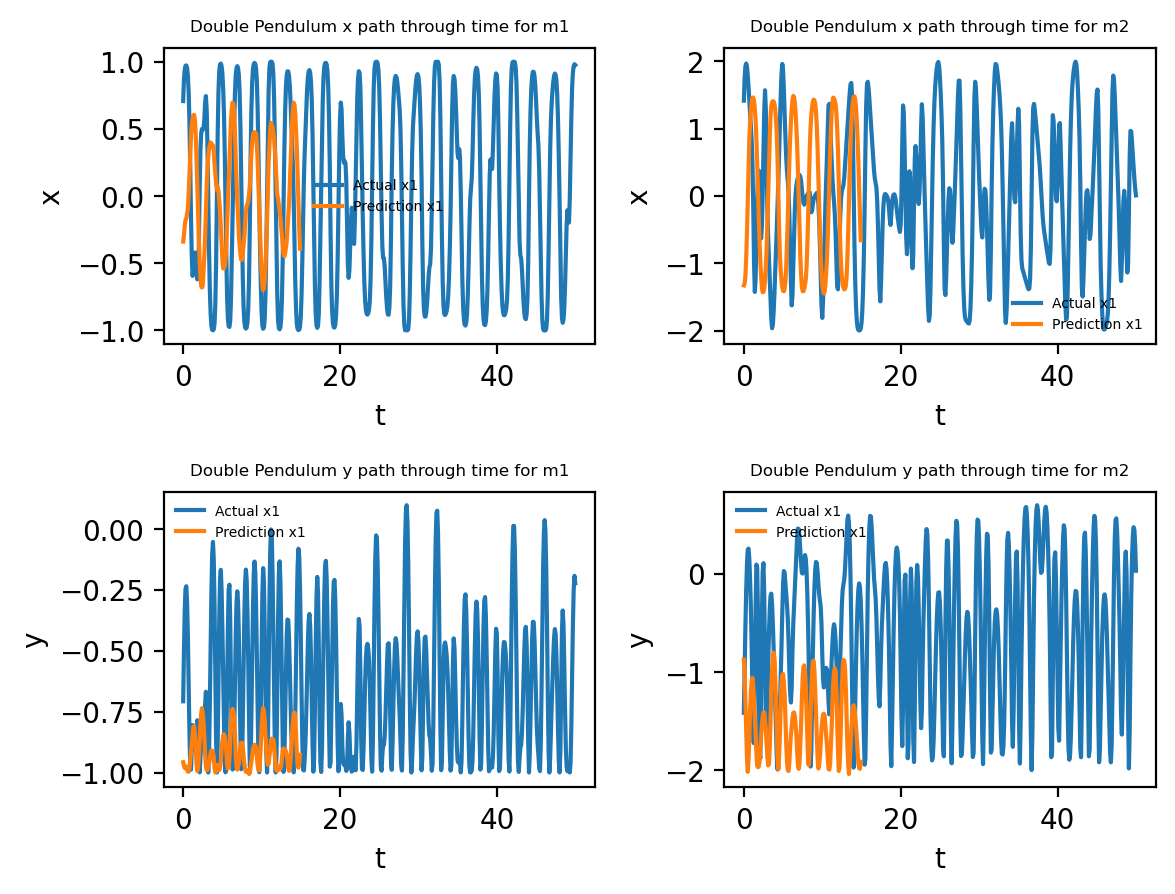

In [511]:
x1,x2,y1,y2 = variation_checker(i=4,j=3)
txy_plotter()

>**By looking at the pendulum plots and the time plots, we can see that the model doesn't predict well when we stray from $z_0=[\pi/4,0,\pi/4,0]$**. In fact, the predictions always seem to be less erratic than the pendulum's movement, as the model was trained on an ordered regime.

_________
## 3. How far into the future can we see?
#### This will be done by making a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, training a new version of the network and then plotting the performance).

#### To begin, we will set the initial conditions back to the original values and calculate the necessary values along with it

In [513]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt) 

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Doing this for y-dataset.
y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]


#stack each x1,y1,x2 or y2 test(or train) data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

(4, 501)


#### Now, we define a function that generates a new model and assigns it a variable

In [514]:
def model():
    '''
    This function returns a pre-made model, which can be assigned into a variable and then trained.
    '''
    
    genmodel=keras.models.Sequential()


    genmodel.add(keras.layers.LSTM(50,input_shape=(None, 4)))       #LSTM layer with 50 neurons. 
                                                                 #Input shape is 4 for each x1,x2,y1 and y2


    genmodel.add(keras.layers.Flatten())                            #from sequential to flat NN:

    genmodel.add(keras.layers.Dense(265, activation='relu'))        #add hidden layer
    genmodel.add(keras.layers.Dense(192, activation='relu'))        #add hidden layer

    genmodel.add(keras.layers.Dense(4, activation='linear'))        #output layer with 4 nueron for each x1, x2, y1 or y2

    genmodel.compile(loss='mean_squared_error',optimizer='adam')    #Compile the model with 'adam' optimizer being used.
    
    return genmodel

Now we generate 17 models that can be trained

In [515]:
modelArray = []

for i in range(17):
    modelgen = model()
    modelArray.append(modelgen)

#### Generating the training and testing data with increasing offset values from 20 to 100. Values vary by +5, so there are 17 datasets generated here.

In [516]:
#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]
inp_tstARRAY =[]
trgt_tstARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,5):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    test_inp, test_lbl = create_dataset(test_data,i, windowsize)

    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1])
    targ_test = test_lbl.reshape(test_lbl.shape[0], test_lbl.shape[1])
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    inp_tstARRAY.append(in_test)
    trgt_tstARRAY.append(targ_test)    

#### Now, we train the model, test it against the testing datset, and then calculate the loss values recieved from the testing.

In [517]:
test_lossArray = []
for i in range(17):
    
    modelN = modelArray[i]
    historyN = modelN.fit(inp_trnARRAY[i], trgt_trnARRAY[i], epochs=30, validation_data= (inp_tstARRAY[i],trgt_tstARRAY[i] ), verbose=0)
    test_lossN = modelN.evaluate(inp_tstARRAY[i], trgt_tstARRAY[i] , verbose=1)
    
    test_lossArray.append(test_lossN)

3/3 [==============================] - 0s 4ms/step - loss: 0.0183


#### And now, we generate a graph of loss .vs. the extrapolation time.

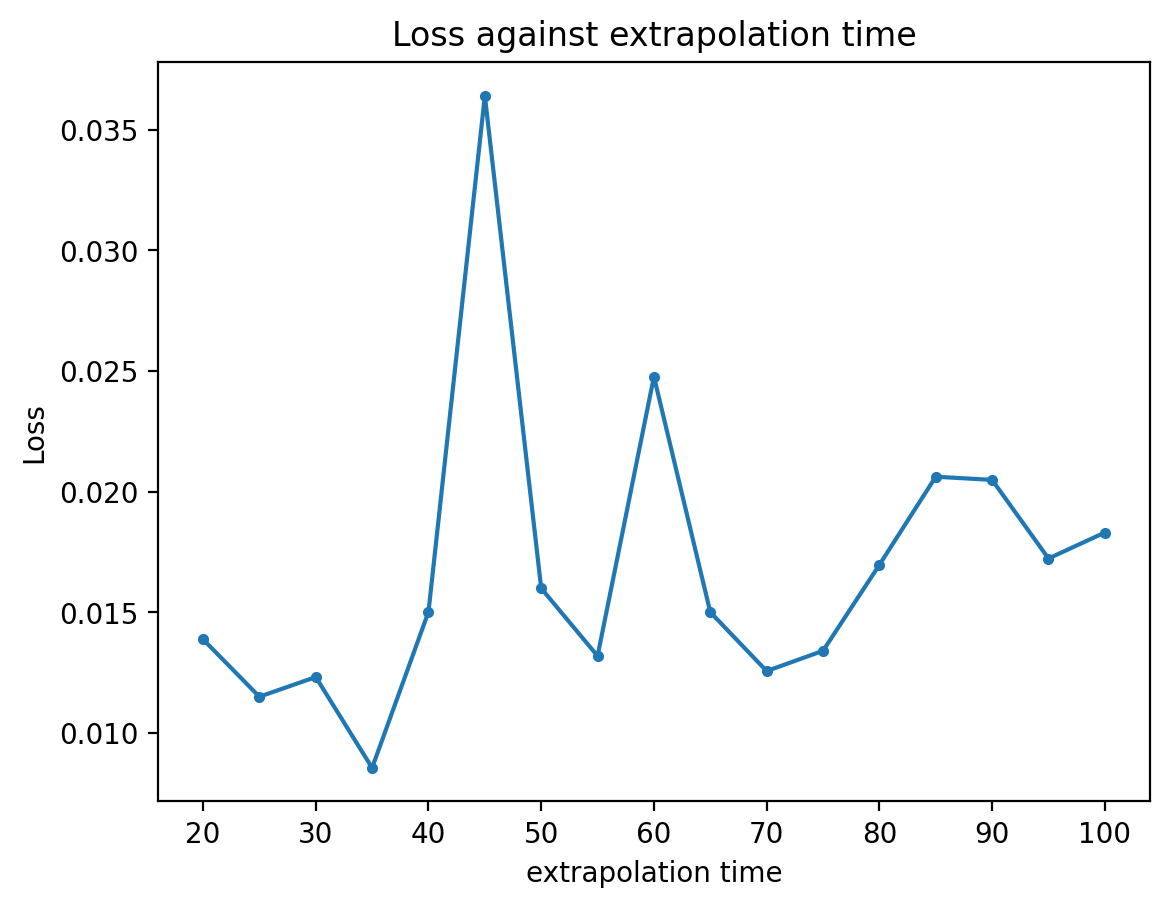

In [518]:
plt.figure()
plt.plot(np.arange(20,101,5), test_lossArray, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

> **Since the initial condition is in a pretty ordered regime, we do not find that much difference in the performance of the networks. This means that we could have gotten similar results for an offset of 20 or 100, which makes sense as the movement produced by those initial conditions are predictable and not very chaotic. But we can see that there is a general trend of increase in loss as extrapolation time increases.**

#### Next, let's look at what happens when we choose chaotic initial conditions.

_________
## 4. Testing under chaotic conditions
#### Here, we will be blitzing through Task 1-3, but under new, more chaotic initial conditions: $z_0=[\pi/2,0,\pi/2,0]$

#### Let's set the initial condtions, calculate the required values and plot a graph of the Double-Pendulum.

(4, 501)


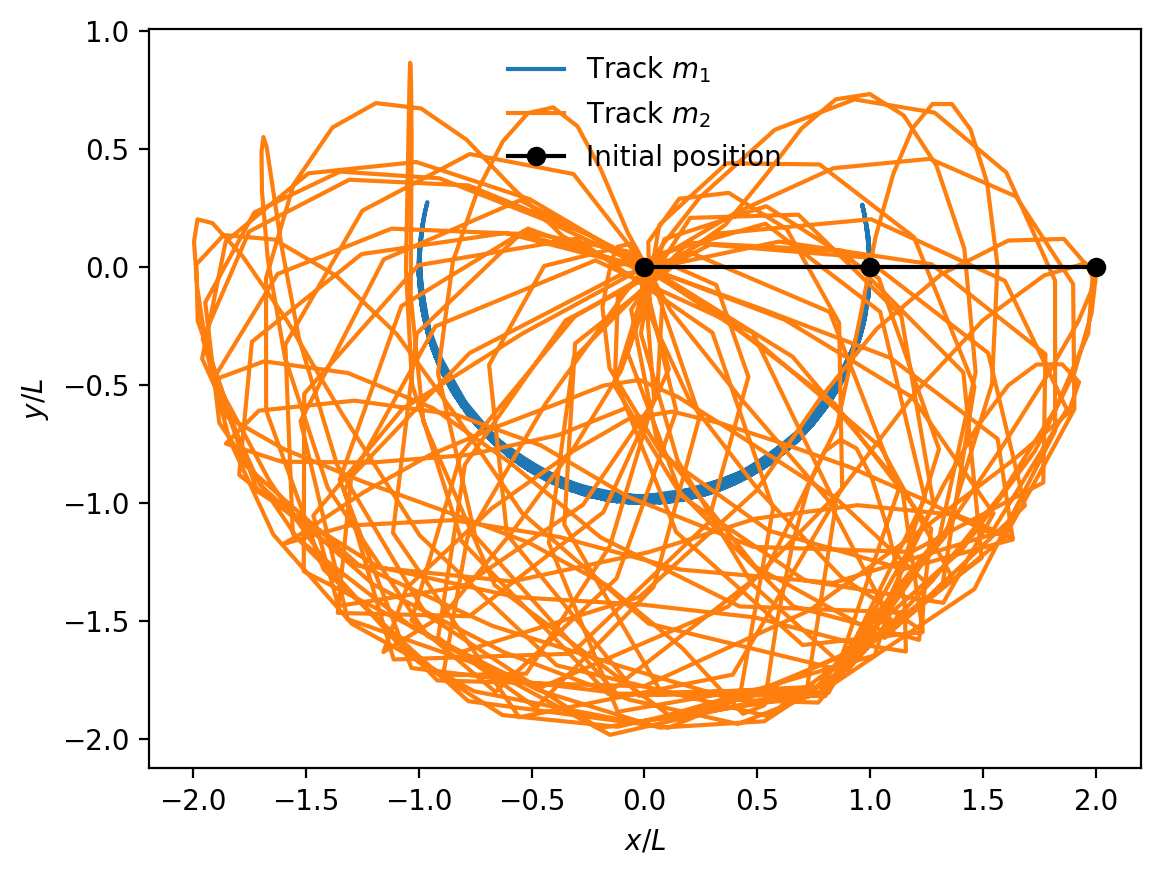

In [519]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()


#### Let's generate a new model, a new dataset for training and testing, and train the network on this dataset.

In [520]:
                        ##Generating the new model##
modelX = model()



          ##Generating the datasets for the training and testing##

y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the full range
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the full range


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]


#stack each x1,y1,x2 or y2 test(or train) data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


#trainng and test dataset(inp=input and tgt=target for NN):
train_inp, train_tgt = create_dataset(train_data,offset, windowsize)
test_inp, test_tgt = create_dataset(test_data,offset, windowsize)

steps=1000  #Number of training steps
costs=np.zeros(steps) #empty array for cost along each step


for i in tqdm(range(steps)):
    
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_tgt.reshape(train_tgt.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    
    #Train the network and store to 'costs' empty array so that we can look at change in cost over steps.
    costs[i]=modelX.train_on_batch(in_train, targ_train)


100%|██████████| 1000/1000 [00:38<00:00, 26.13it/s]


#### Now, let's check how the cost varies with each step and how accurate the model's predictions are.

0.0002951958740595728

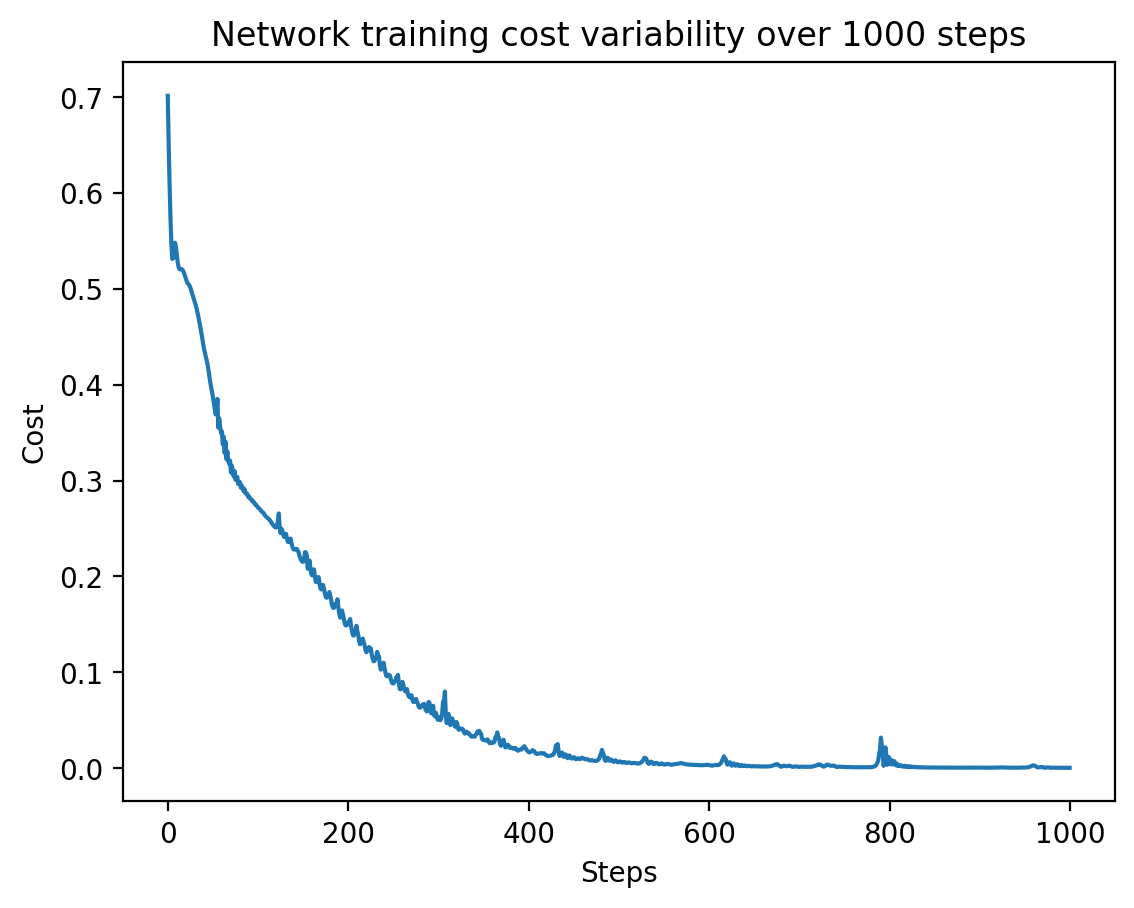

In [521]:
               ##How the cost varies with each step##
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network training cost variability over 1000 steps")
costs[-1]

(150, 4)
(70, 4)


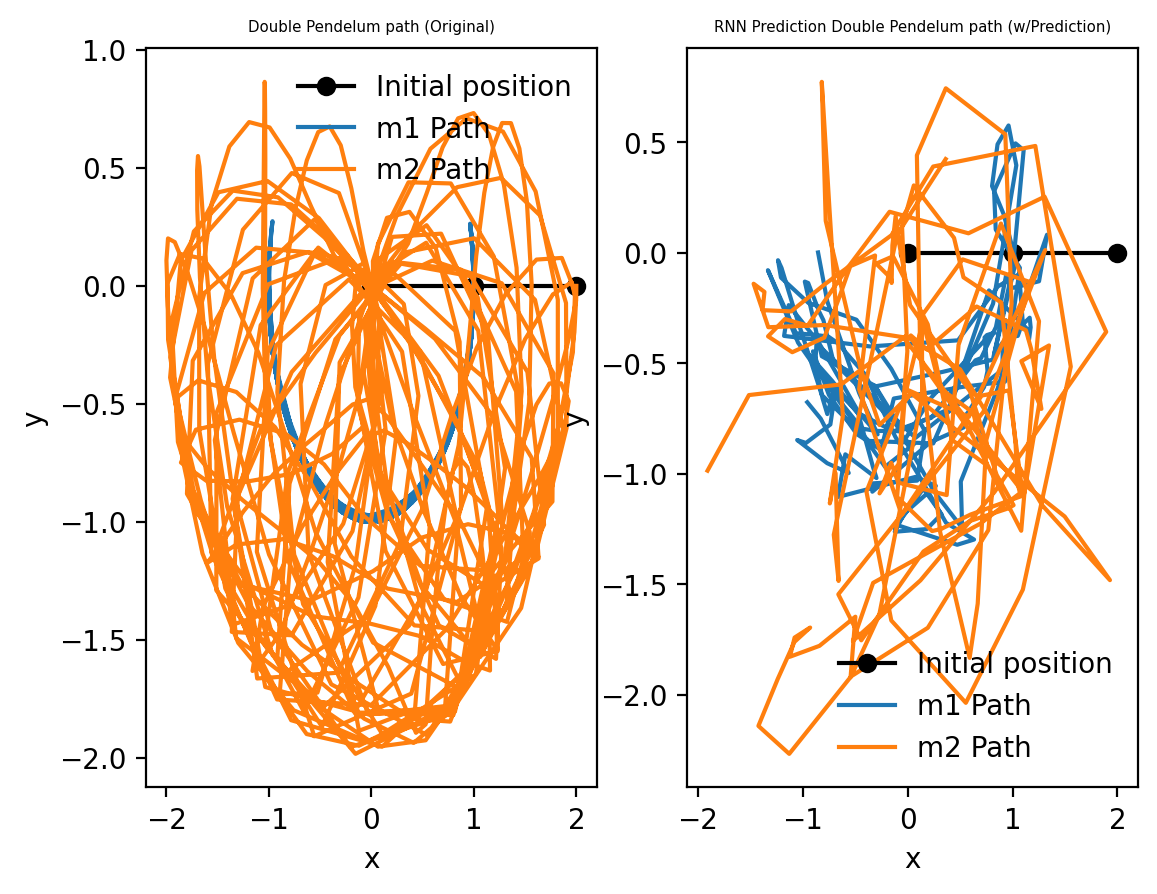

In [522]:
            ##Checking the accuracy of the predictions##
#Reshaping the test input data for the same reasons we did for the training input data before training the RNN
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)


test=modelX.predict_on_batch(in_test) #gives output from RNN
print(test.shape)
print(test_lbl.shape) #lbl = target

fig,ax=plt.subplots(nrows=1, ncols=2, )

#Plot for original double-pendulum movement:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path (Original)", size=5.4)
ax[0].legend()

#Plot of double-pendulum from prediction of RNN:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path (w/Prediction)", size=5.4)
ax[1].legend()

> **Here, we can see that the model is finding prediction a lot harder in this case. The chaotic motion caused by the initial conditions is a lot hareder to predict on. This is most evident in how well the model predicts m1 vs m2 motion. While m1 gets a comparitively decent prediction, m2's erratic motion results in a really bad prediction**

#### Next, let's check the stability of this network against variations in initial conditions.

#### For initial conditions: $z_0=[\pi/4,0,\pi/4,0]$. 
Varying the $\theta$-values

(4, 501)


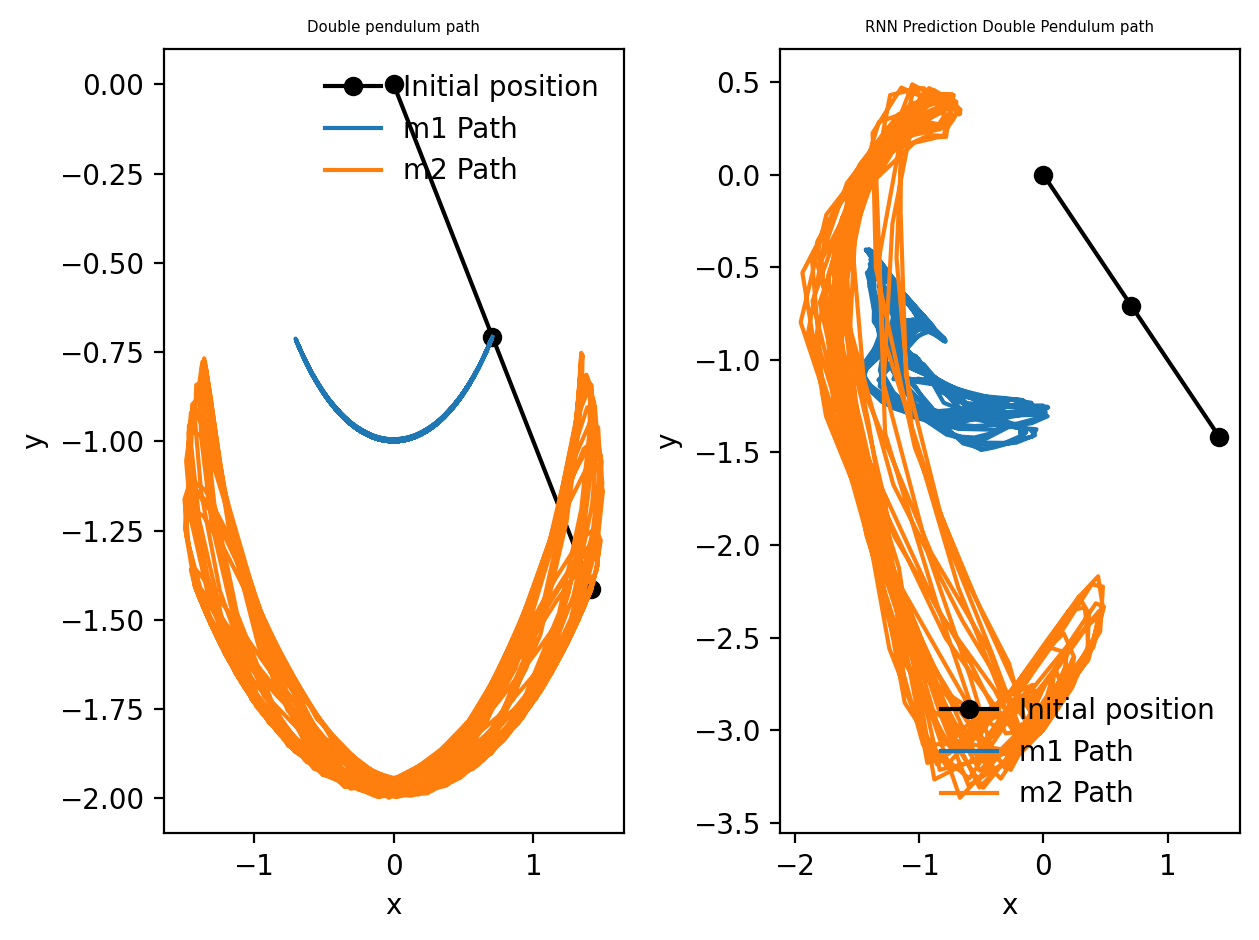

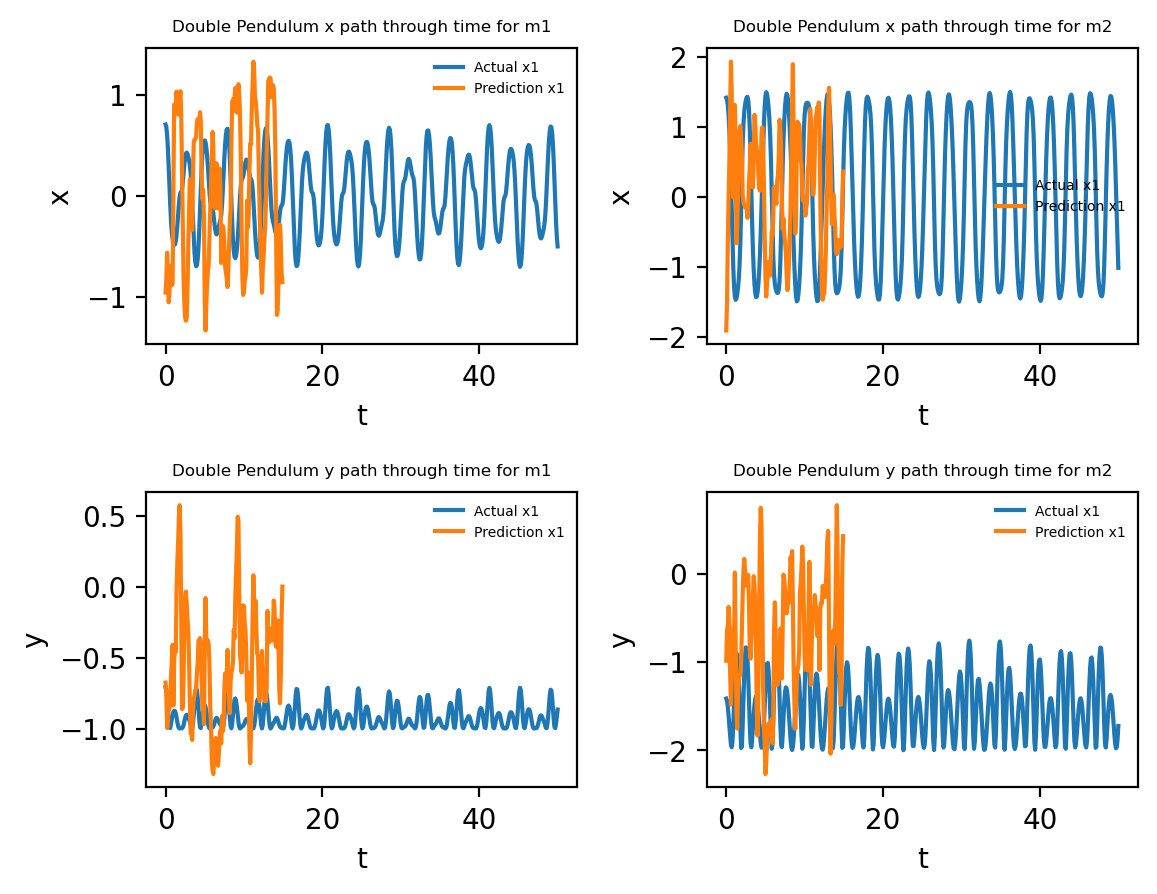

In [523]:
x1,x2,y1,y2 = variation_checker(i=4,j=0,model=modelX)
txy_plotter()

#### For initial conditions: $z_0=[\pi/2,1,\pi/2,1]$.
Varying the $\omega$-values

(4, 501)


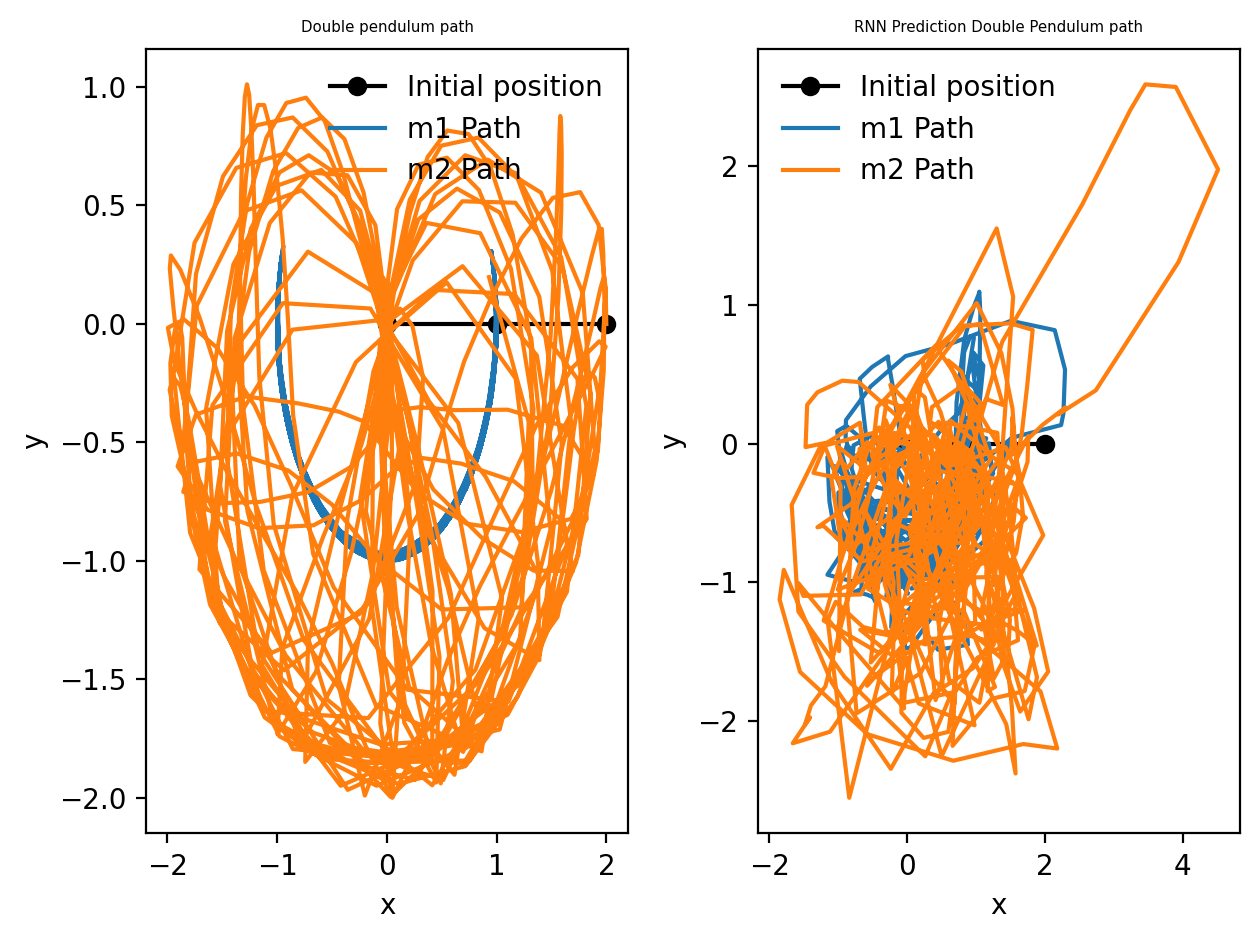

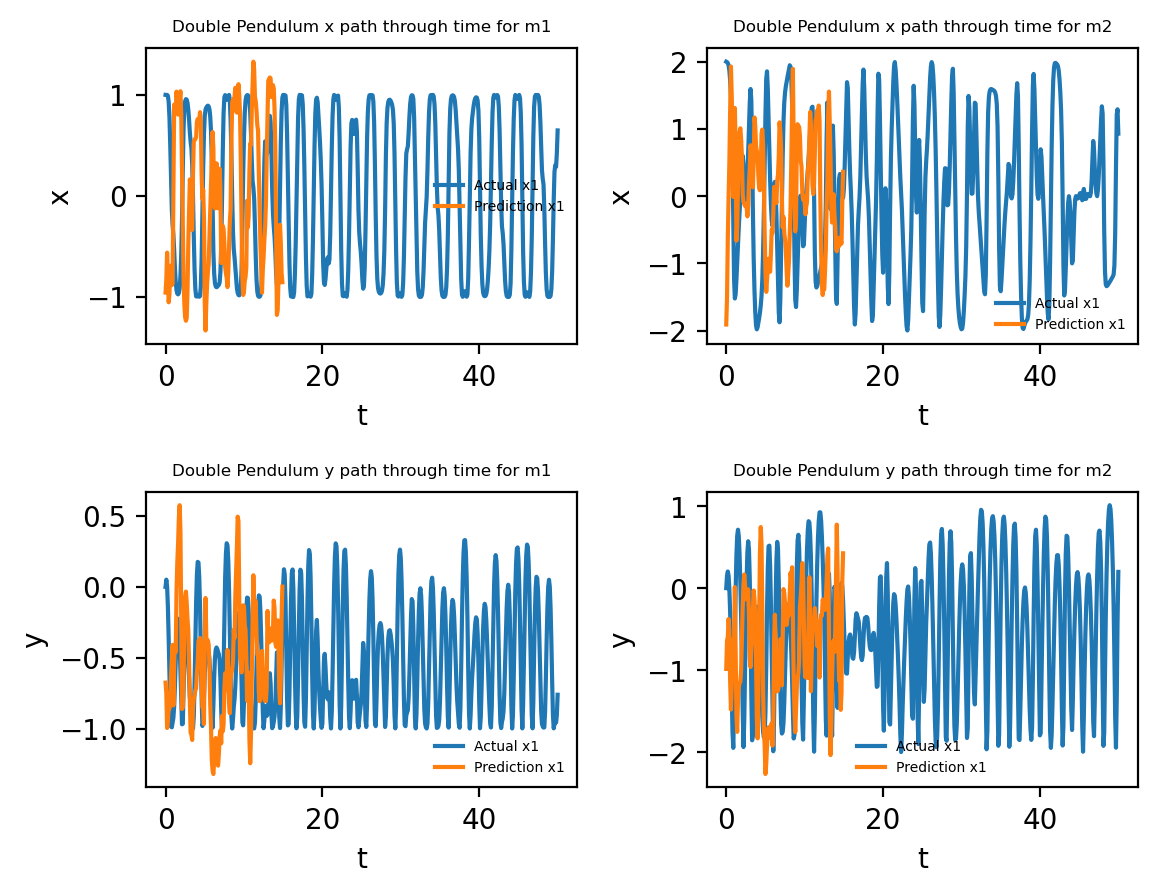

In [524]:
x1,x2,y1,y2 = variation_checker(i=2,j=1,model=modelX)
txy_plotter()

#### For initial conditions: $z_0=[\pi/4,2,\pi/4,2]$.
Varying both.

(4, 501)


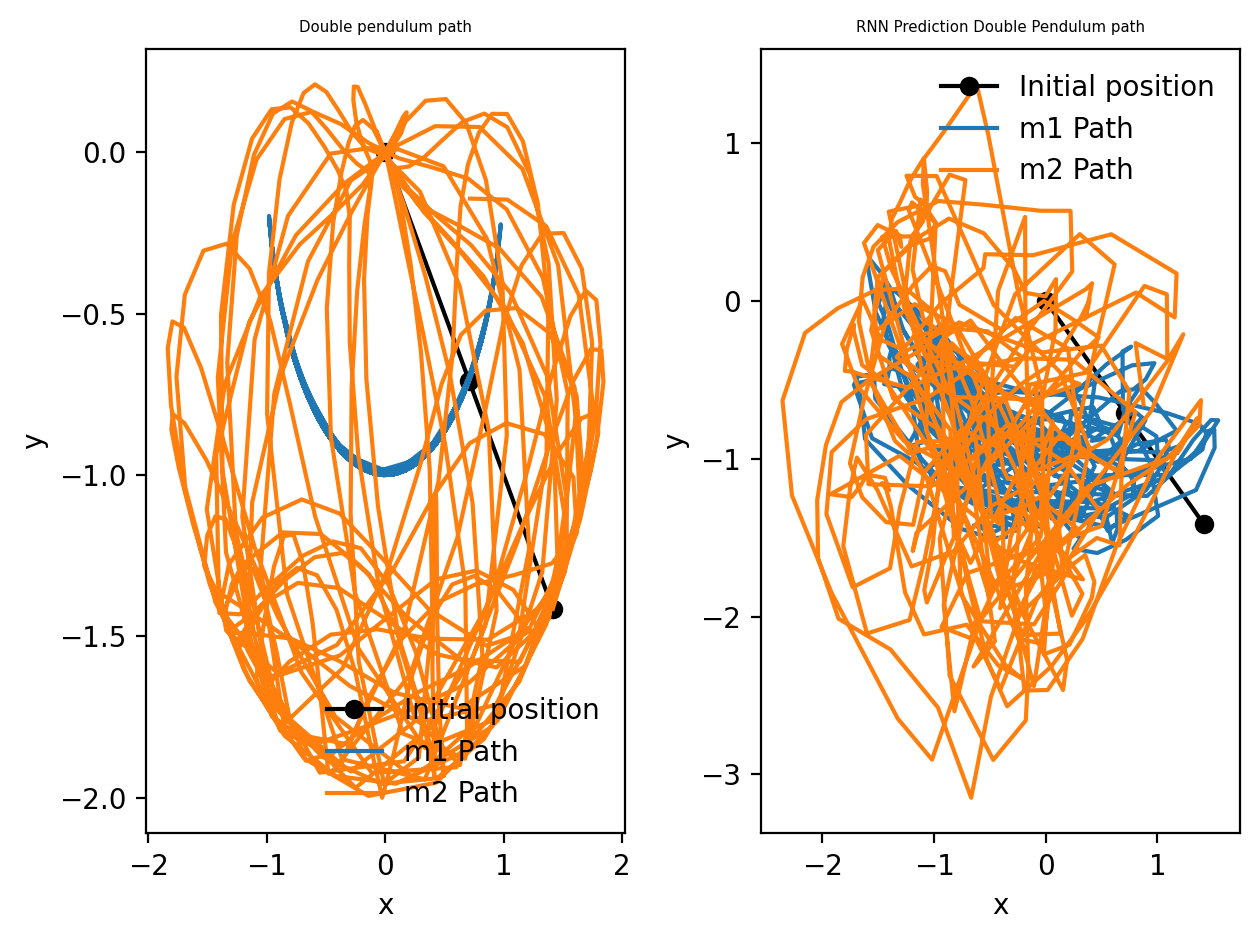

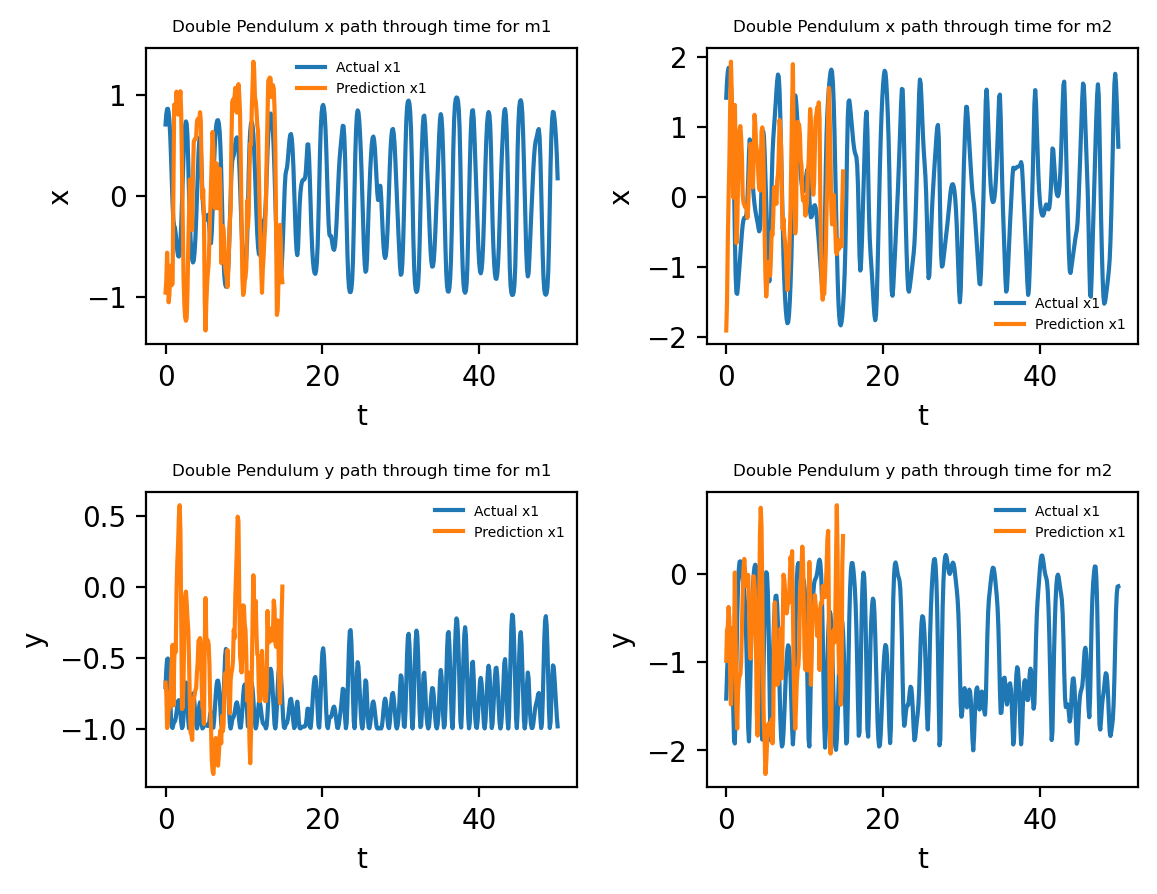

In [525]:
x1,x2,y1,y2 = variation_checker(i=4,j=2,model=modelX)
txy_plotter()

> Looking at the results from varying $\theta$ and $\omega$, we can see that this model deals poorly with variation in initial conditions. Here, we see a general trend of the predictions being a lot more chaotic than the actual movements, which is an expected result as the model expects very chaotic data to be fed in.

#### Now, let's see how far into the future the model (with Part-4's initial conditions) can predict well.

In [526]:
##Here, we switch back to Part 4's original initial conditions and calculate relevant values.###

# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt) 

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Doing this for y-dataset.
y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the full range
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the full range


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]


#stack each x1,y1,x2 or y2 test(or train) data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

(4, 501)


#### Next, we generate 17 models and datasets that will check the performance of a model trained on the values above and tested on offsets that go from 20 to 100

3/3 [==============================] - 0s 5ms/step - loss: 1.1738


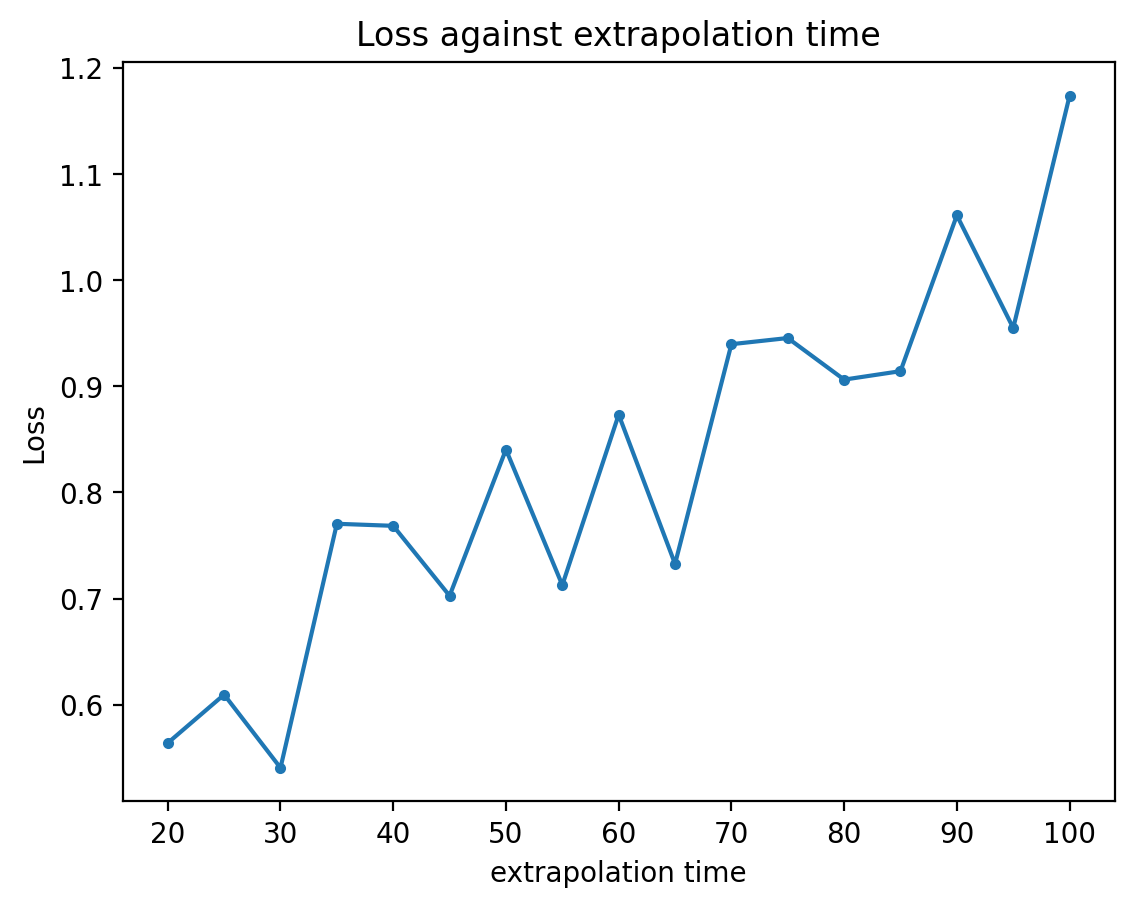

In [527]:
##Generating the Model-array##
modelarray = []

for i in range(17):
    modelGen = model()
    modelarray.append(modelGen)

##Generating the datasets to train and test the model
#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]
inp_tstARRAY =[]
trgt_tstARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,5):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    test_inp, test_lbl = create_dataset(test_data,i, windowsize)

    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1])
    targ_test = test_lbl.reshape(test_lbl.shape[0], test_lbl.shape[1])
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    inp_tstARRAY.append(in_test)
    trgt_tstARRAY.append(targ_test) 
    
    
##Testing the models on the varying extrapolation-times and calculating the loss-values.##
test_lossarray = []
for i in range(17):
    
    modelM = modelarray[i]
    historyM = modelM.fit(inp_trnARRAY[i], trgt_trnARRAY[i], epochs=30, validation_data= (inp_tstARRAY[i],trgt_tstARRAY[i] ), verbose=0)
    test_lossM = modelM.evaluate(inp_tstARRAY[i], trgt_tstARRAY[i] , verbose=1)
    
    test_lossarray.append(test_lossM)
    
##Generating a plot of loss .vs. extrapolation time.##
plt.figure()
plt.plot(np.arange(20,101,5), test_lossarray, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

> Here, as expected, the performance of the networks is quite low in comparison to the models trained with less chaotic initial conditions. thus, the loss values in the graph above are much higher. But in the graph above, we can better see the effect of increasing extrapolation time on the performance of the network. As the offset is increased linearly, the performance decreases somewhat linearly.

_________
## 5. How far into the future can we see with one eye closed?
#### This will be done by repeating Steps 1-4 but only training our neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing our neural network the positions of the mass $m_1$).


#### First, let's begin by setting up the initial condition as $[\pi/4,0,\pi/4,0]$, calculate the necessary values, and plot the double pendulum for reference.

(4, 501)


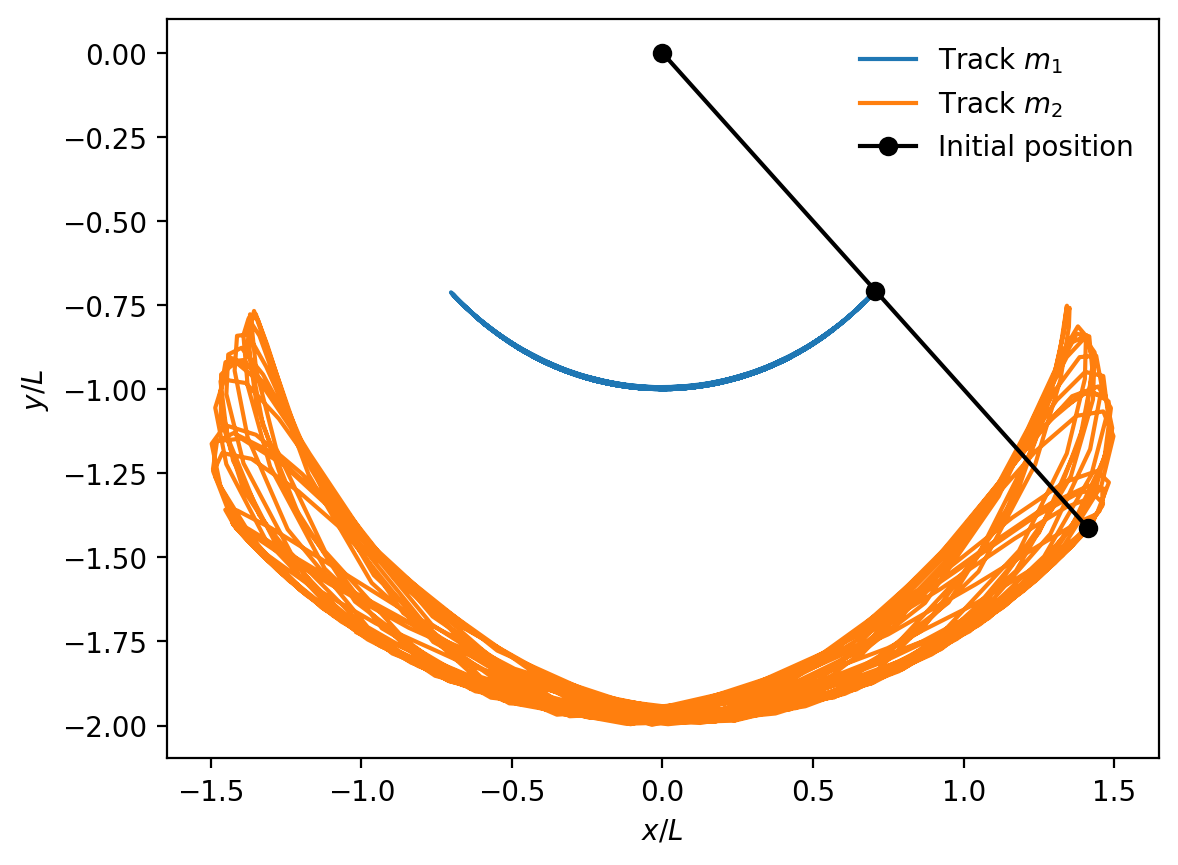

In [538]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

#### Since any models trained in Part 4 are trained on just $m_2$ data, we can redefine the model-generating function to take an input-shape of 2 and output the same shape as well.


In [539]:
def model2():
    '''
    This function returns a pre-made model, which can be assigned into a variable and then trained.
    '''
    
    genmodel=keras.models.Sequential()


    genmodel.add(keras.layers.LSTM(50,input_shape=(None, 2)))       #LSTM layer with 50 neurons. 
                                                                 #Input shape is 4 for each x1,x2,y1 and y2


    genmodel.add(keras.layers.Flatten())                            #from sequential to flat NN:

    genmodel.add(keras.layers.Dense(265, activation='relu'))        #add hidden layer
    genmodel.add(keras.layers.Dense(192, activation='relu'))        #add hidden layer

    genmodel.add(keras.layers.Dense(2, activation='linear'))        #output layer with 4 nueron for each x1, x2, y1 or y2

    genmodel.compile(loss='mean_squared_error',optimizer='adam')    #Compile the model with 'adam' optimizer being used.
    
    return genmodel

#### Now, we generate the model, generate testing and training data, and train the model on these datasets (generating the costs over steps). But there is one key difference, the model is only trained on the $m_2$ dataset.

In [540]:
##Generating the model##
model = model2()

##Generating the datasets##
#We train the RNN over a limited range of the y data and x data and test it over the full range:

#Doing this for y-dataset.
y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]


#Generating the m1 and m2 test-data SEPARATELY
test_data1 = np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#Generating the training data based on m2
train_data = np.column_stack((x2_train, y2_train)).T


windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


#trainng and test dataset(inp=input and tgt=target for NN):
train_inp, train_tgt = create_dataset(train_data,offset, windowsize)
test_inp1, test_tgt1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_tgt2 = create_dataset(test_data2,offset, windowsize)


steps=1000  #Number of training steps
costs=np.zeros(steps) #empty array for cost along each step


for i in tqdm(range(steps)):
    
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_tgt.reshape(train_tgt.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    
    #Train the network and store to 'costs' empty array so that we can look at change in cost over steps.
    costs[i]=model.train_on_batch(in_train, targ_train)

100%|██████████| 1000/1000 [00:37<00:00, 26.47it/s]


#### Let's look at how the cost changes as the steps progress and what the final cost value was.

The final cost for training data is 0.001018647220917046


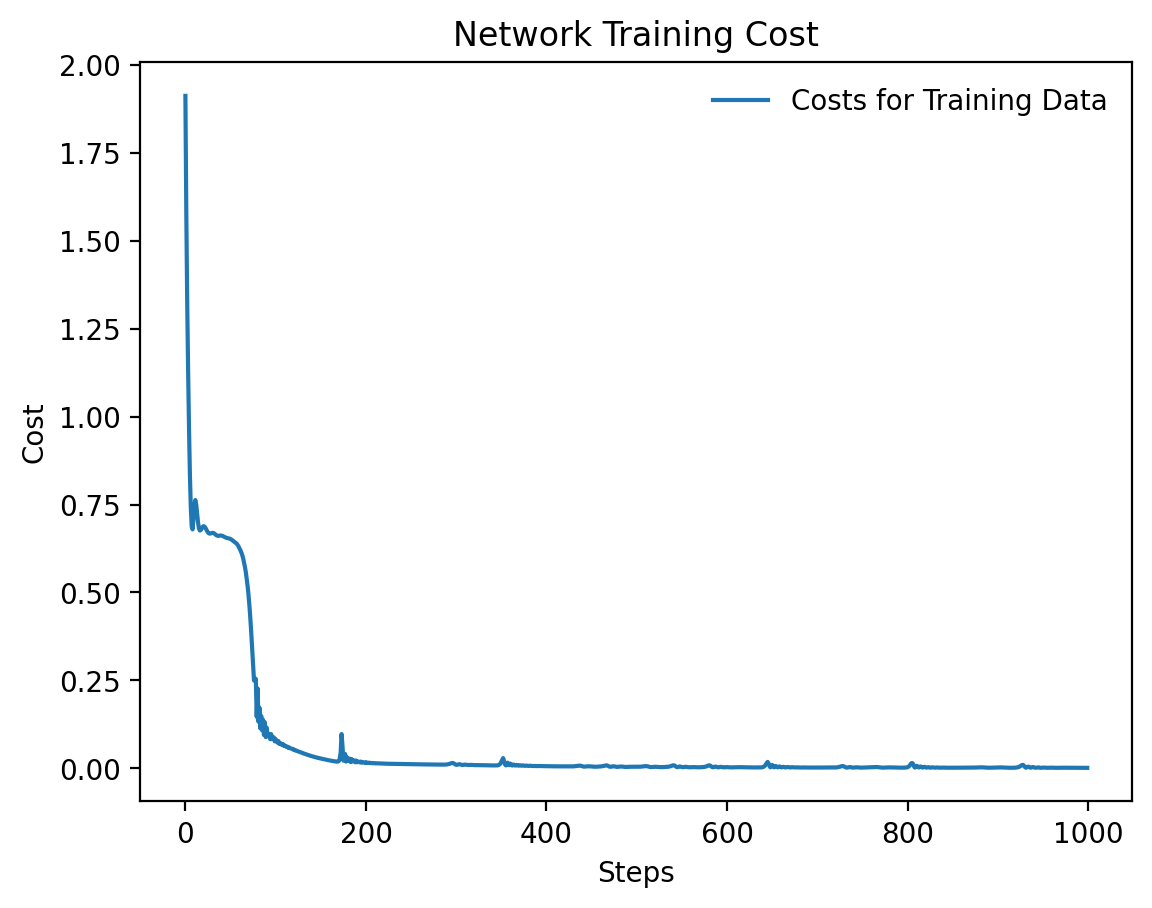

In [541]:
#plot train cost:
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

print("The final cost for training data is",costs[-1])

> The final cost is comparable to the cost achieved at the beginning of this notebook, which is pretty good. The cost graph, as before, seems to stabilize at around 200 steps and maintains spikey features.

#### Now, let's check the accuracy of our model's predictions.

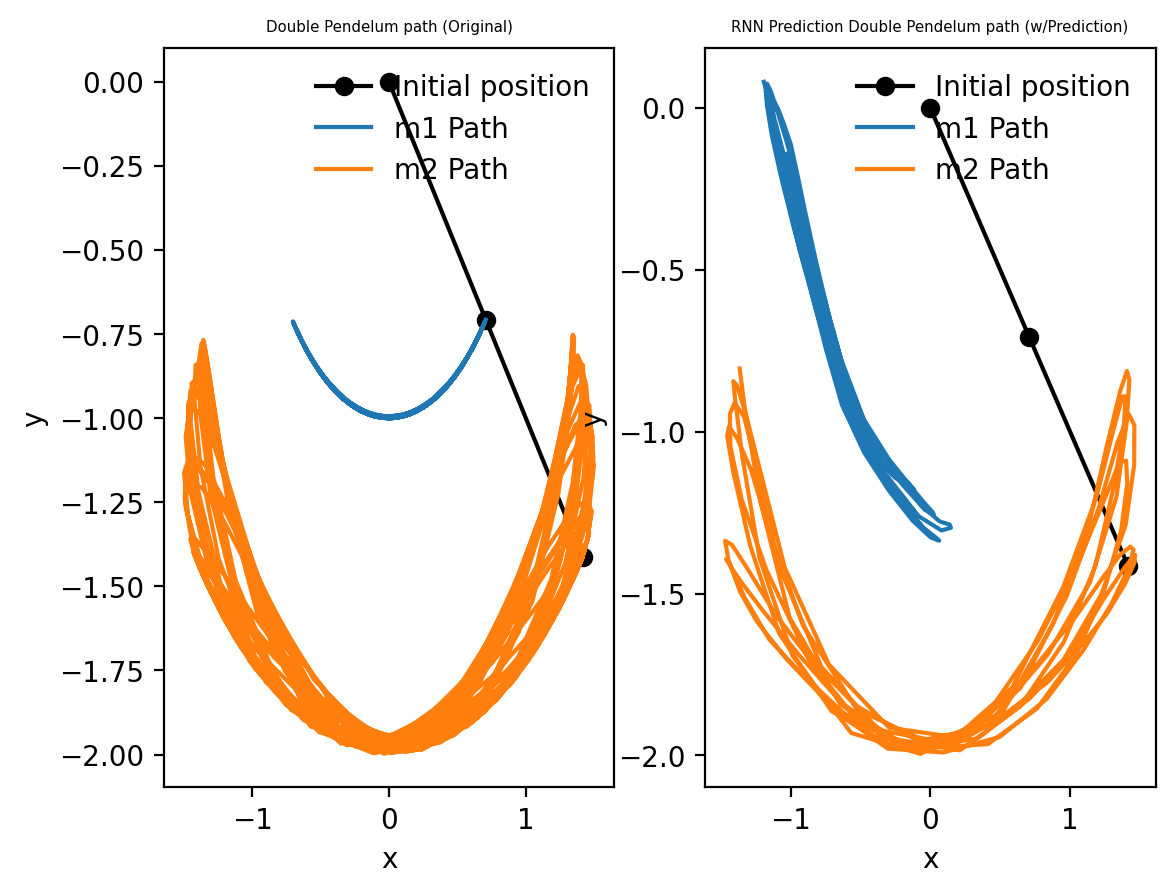

In [544]:
#Reshaping the test input data for the same reasons we did for the training input data before training the RNN
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=model.predict_on_batch(in_test1) #gives output from RNN
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=model.predict_on_batch(in_test2) #gives output from RNN


fig,ax=plt.subplots(nrows=1, ncols=2, )

#Plot for original double-pendulum movement:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path (Original)", size=5.4)
ax[0].legend()

#Plot of double-pendulum from prediction of RNN:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path (w/Prediction)", size=5.4)
ax[1].legend()

> Here we can see that although the model predicts the more chaotic movements of $m_2$ pretty well, the predictible movements of $m_1$ are predicted pretty badly.

#### Now, let's check the stability of this network to variations in initial conditions without retraining the network.

#### Firstly, we need to redefine the variation_checker and txy_plotter functions to generate the testing dataset based on just $m_2$, plot the doule pendulums, and plot x and y .vs. time

In [554]:
def variation_checker2(i,j,model=model):
    '''
    Takes in i&j as variables that affect the initial conditions of the double pendulum and generates a plot of the double
    pendulum's movement and a plot of the RNN's prediction of said movement.
    
    Inputs:
      -i should realistically be between 0 and 1 as is the denominator to pi. Used to generate theta1 & theta2.
      -j can be any value. Used to generate w1 and w2
      -model which is being used to generate the predictions. Defaults to the model for Part 1.
      
    Outputs:
      -Generates the plots of Double pendulum and RNN's prediction of it.
      -Returns the values of x1, x2, y1, y2 which should be stored in that order and naming scheme to further use the t-xy 
       function.
    '''
                          #########################################################
                          ##Changing the initial conditions and running rhs again##
                          #########################################################
        
    #Starting angles
    z0=[np.pi/i,j,np.pi/i,j]    #Changes depending on the value of 'i' input.

    #Time ranges
    tmax, dt = 50, 0.1
    t = np.arange(0, tmax+dt, dt)

    # Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y
    print(np.shape(z))

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    
                        ###############################################################
                        ##Creating the training and testing datasets (same as before)##
                        ###############################################################
    
    #Doing this for y-dataset.
    y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
    y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
    y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
    y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


    #And now the same as above, but for x
    x1_train=x1[0:int(0.6*len(x1))] 
    x2_train=x2[0:int(0.6*len(x2))] 
    x1_test=x1[int(0.6*len(x1)):-1]
    x2_test=x2[int(0.6*len(x2)):-1]

    #Generating the m1 and m2 test-data SEPARATELY
    test_data1 = np.column_stack((x1_test, y1_test)).T
    test_data2 = np.column_stack((x2_test, y2_test)).T
    #Generating the training data based on m2
    train_data = np.column_stack((x2_train, y2_train)).T


    windowsize=30 #Number of samples we will use to train our network
    offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


    #trainng and test dataset(inp=input and tgt=target for NN):
    train_inp, train_tgt = create_dataset(train_data,offset, windowsize)
    test_inp1, test_tgt1 = create_dataset(test_data1,offset, windowsize)
    test_inp2, test_tgt2 = create_dataset(test_data2,offset, windowsize)

    
                                    ########################################
                                    ##Testing and plotting the predictions##
                                    ########################################
    
    #Reshaping the test input data for the same reasons we did for the training input data before training the RNN
    in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    test1=model.predict_on_batch(in_test1) #gives output from RNN
    in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    test2=model.predict_on_batch(in_test2) #gives output from RNN


    fig,ax=plt.subplots(nrows=1, ncols=2, )

    #Plot for original double-pendulum movement:
    ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
    ax[0].plot(x1,y1,label="m1 Path")
    ax[0].plot(x2,y2,label="m2 Path")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].set_title("Double Pendelum path (Original)", size=5.4)
    ax[0].legend()

    #Plot of double-pendulum from prediction of RNN:
    ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
    ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
    ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")
    ax[1].set_title("RNN Prediction Double Pendelum path (w/Prediction)", size=5.4)
    ax[1].legend()


    fig.tight_layout()
    
    return x1,x2,y1,y2   #This is to be stored in variables of the same name to then be used to generate the t-xy plot.

def txy_plotter2():    
    fig,ax=plt.subplots(nrows=2, ncols=2, )

    #m1_x:
    ax[0,0].plot(t,x1,label="Actual x1")
    ax[0,0].plot(t[:len(test1[:,0])],test[:,0],label="Prediction x1")
    ax[0,0].set_xlabel("t")
    ax[0,0].set_ylabel("x")
    ax[0,0].set_title("Double Pendulum x path through time for m1", size=6)
    ax[0,0].legend(prop={'size':5})

    #m2_x:
    ax[0,1].plot(t,x2,label="Actual x1")
    ax[0,1].plot(t[:len(test2[:,0])],test[:,2],label="Prediction x1")
    ax[0,1].set_xlabel("t")
    ax[0,1].set_ylabel("x")
    ax[0,1].set_title("Double Pendulum x path through time for m2", size=6)
    ax[0,1].legend(prop={'size':5})

    #m1_y:
    ax[1,0].plot(t,y1,label="Actual x1")
    ax[1,0].plot(t[:len(test1[:,1])],test[:,1],label="Prediction x1")
    ax[1,0].set_xlabel("t")
    ax[1,0].set_ylabel("y")
    ax[1,0].set_title("Double Pendulum y path through time for m1", size=6)
    ax[1,0].legend(prop={'size':5})

    #m2_y:
    ax[1,1].plot(t,y2,label="Actual x1")
    ax[1,1].plot(t[:len(test2[:,1])],test[:,3],label="Prediction x1")
    ax[1,1].set_xlabel("t")
    ax[1,1].set_ylabel("y")
    ax[1,1].set_title("Double Pendulum y path through time for m2", size=6)
    ax[1,1].legend(prop={'size':5})
    
    plt.subplots_adjust(
                    wspace=0.3, hspace=0.5)  #Adjust the space between the subplots to make it organized.

#### For initial conditions: $z_0=[\pi/2,0,\pi/2,0]$

(4, 501)


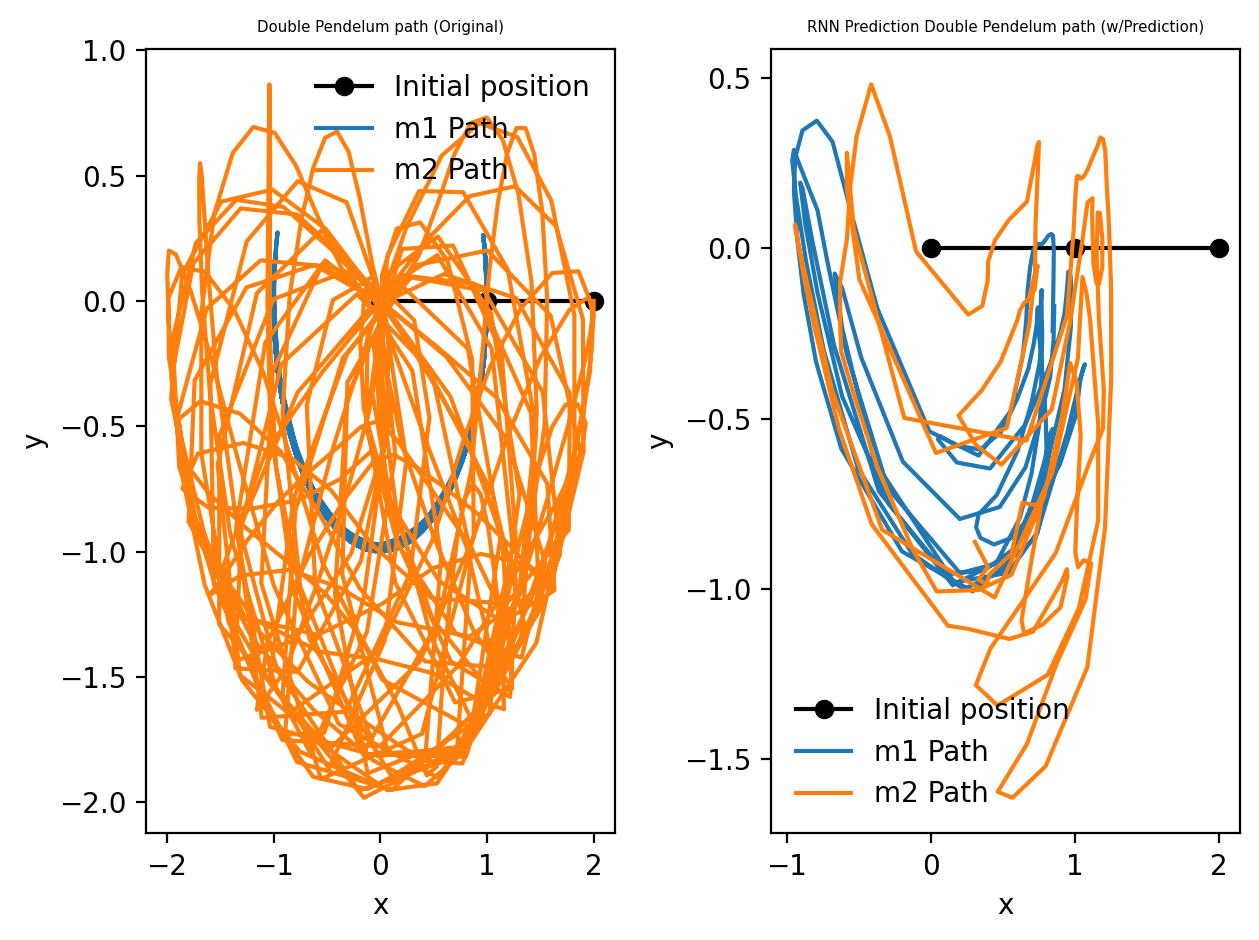

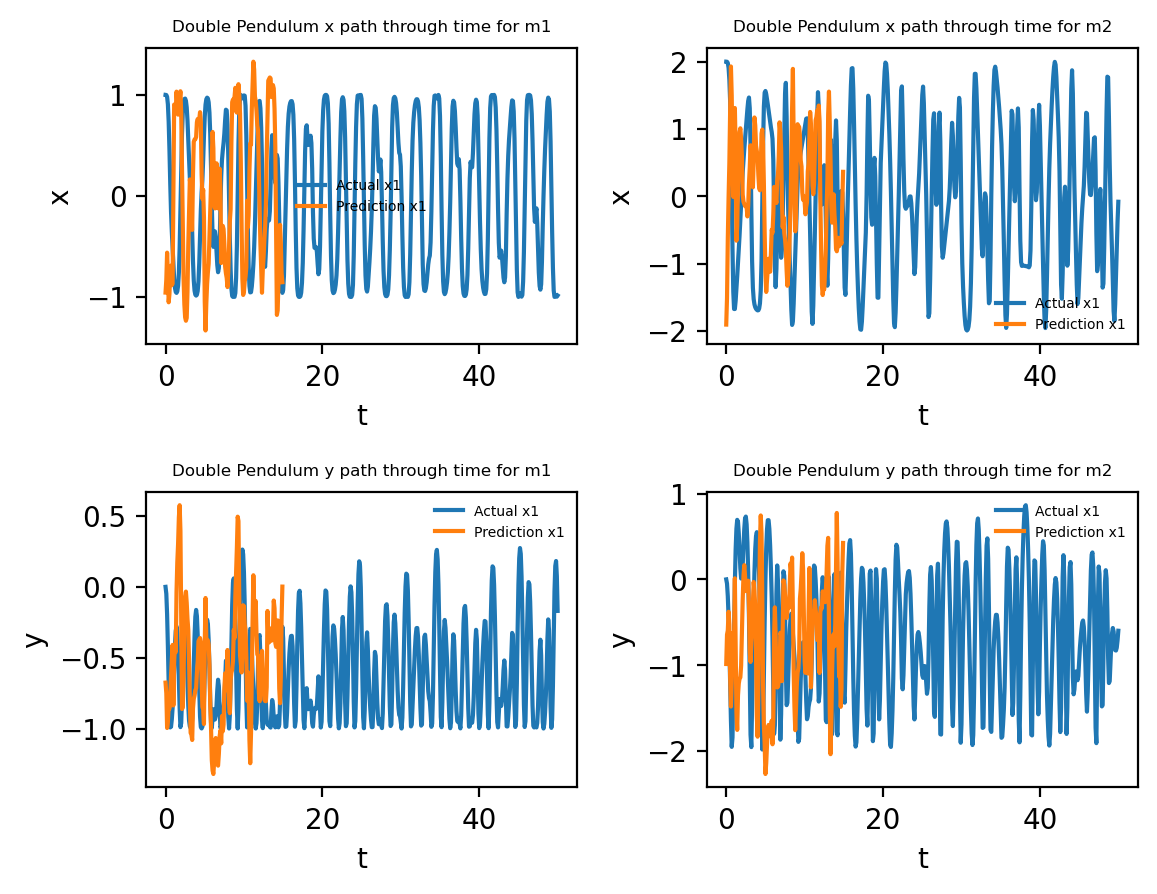

In [555]:
x1,x2,y1,y2 = variation_checker2(i=2,j=0)
txy_plotter2()

#### For initial conditions: $z_0=[\pi/4,3,\pi/4,3]$

(4, 501)


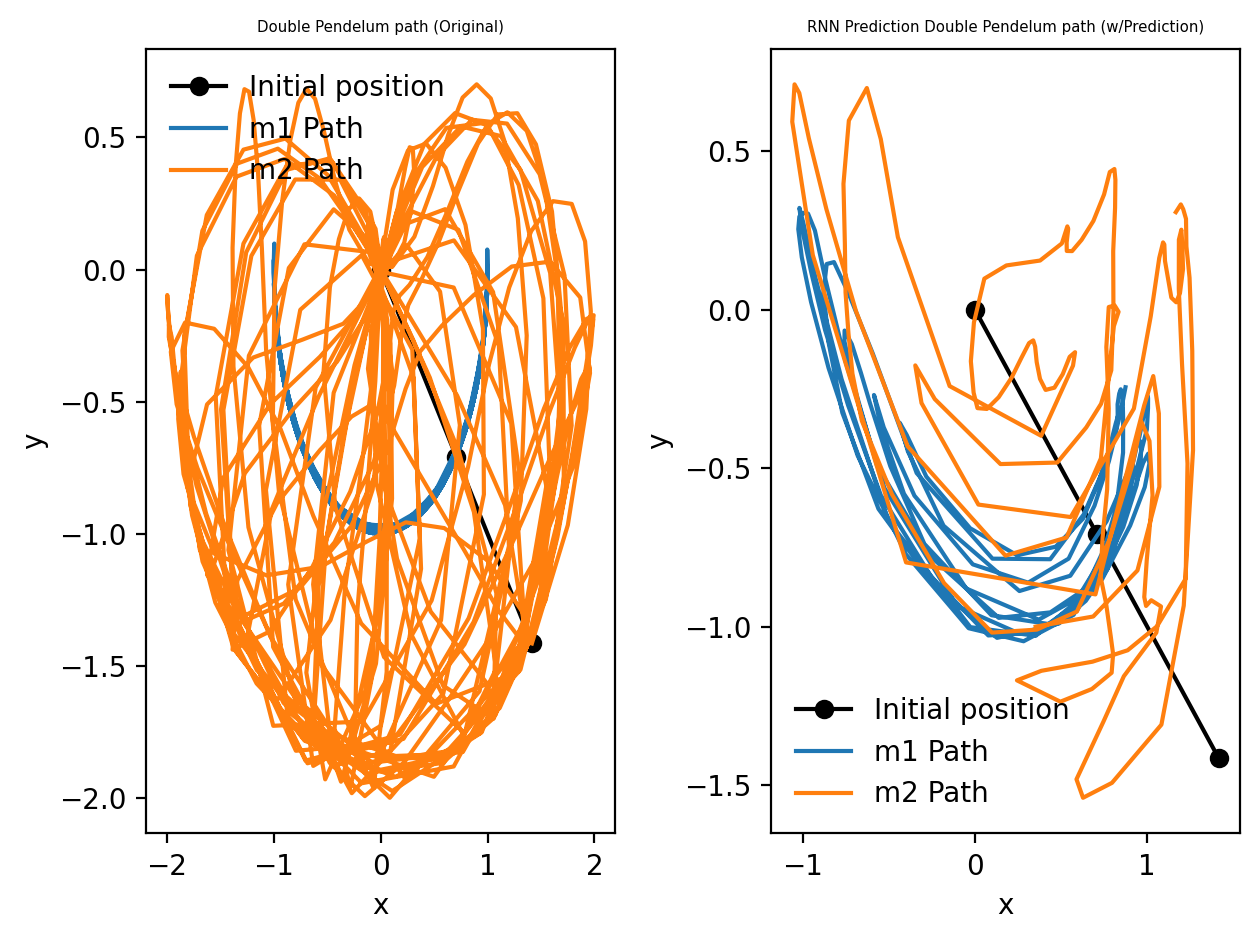

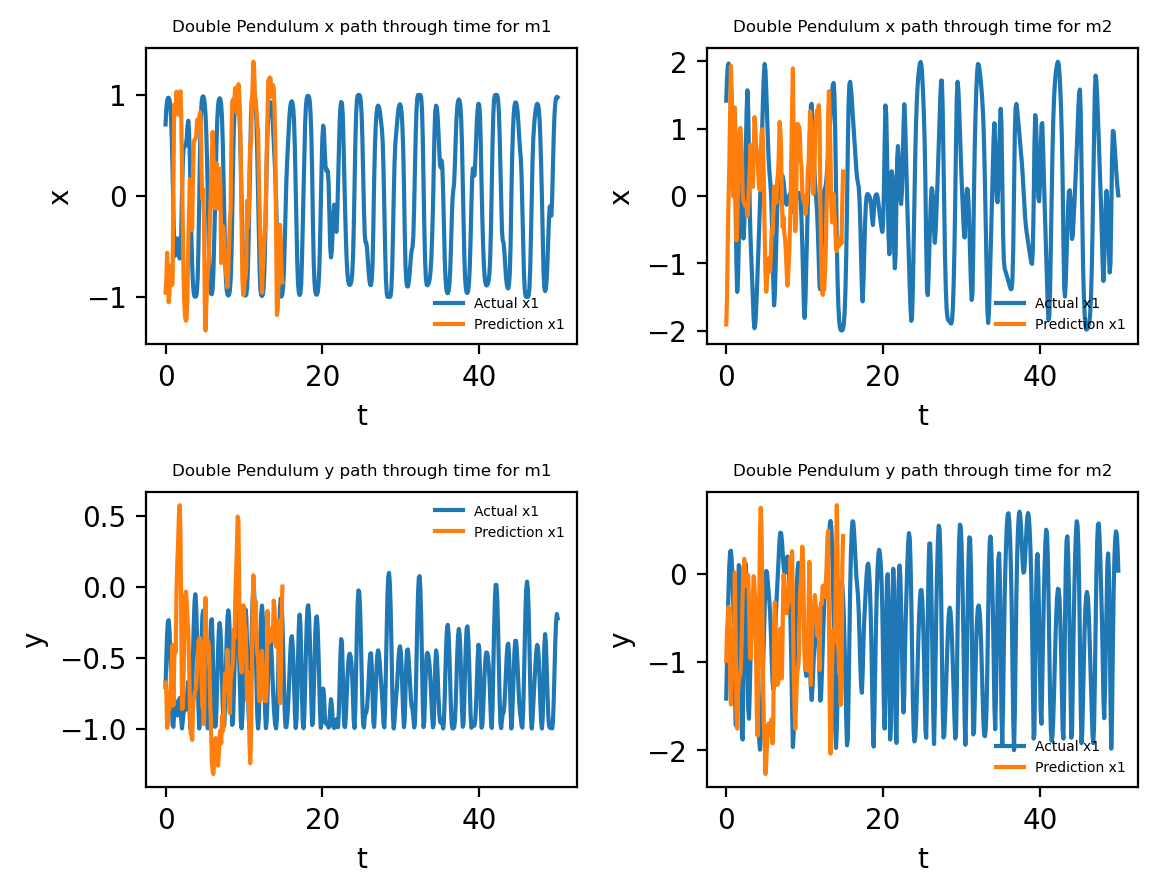

In [557]:
x1,x2,y1,y2 = variation_checker2(i=4,j=3)
txy_plotter()


> The model seems to be pretty bad at predicting $m_1$ and even worse at predicting $m_2$. 

#### Now let's check the quality of predicitions given by models that are trained on varying offset-values (extrapolation time).

#### To begin, we will set the initial conditions back to the original values and calculate the necessary values along with it

In [562]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

                    ###############################################################
                    ##Creating the training and testing datasets (same as before)##
                    ###############################################################

#Doing this for y-dataset.
y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]

#Generating the m1 and m2 test-data SEPARATELY
test_data1 = np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#Generating the training data based on m2
train_data = np.column_stack((x2_train, y2_train)).T

(4, 501)


#### Now we generate 17 models that can be trained

In [563]:
modelArray = []

for i in range(17):
    modelgen = model2()
    modelArray.append(modelgen)

#### Generating the training and testing data with increasing offset values from 20 to 100. Values vary by +5, so there are 17 datasets generated here.

In [564]:
#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]
inp_tst1ARRAY =[]
trgt_tst1ARRAY=[]
inp_tst2ARRAY =[]
trgt_tst2ARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,5):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    test_inp1, test_lbl1 = create_dataset(test_data1,i, windowsize)
    test_inp2, test_lbl2 = create_dataset(test_data2,i, windowsize)
    
    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1])
    targ_test1 = test_lbl1.reshape(test_lbl1.shape[0], test_lbl1.shape[1])
    in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1])
    targ_test2 = test_lbl2.reshape(test_lbl2.shape[0], test_lbl2.shape[1])    
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    inp_tst1ARRAY.append(in_test1)
    trgt_tst1ARRAY.append(targ_test1)    
    inp_tst2ARRAY.append(in_test2)
    trgt_tst2ARRAY.append(targ_test2)    

#### Now, we train the model, test it against the testing datset, and then calculate the loss values recieved from the testing.

In [567]:
test_loss1Array = []
test_loss2Array = []

for i in range(17):
    
    modelM = modelArray[i]
    historyM = modelM.fit(inp_trnARRAY[i], trgt_trnARRAY[i], epochs=30, verbose=0)
    test_lossN1 = modelM.evaluate(inp_tst1ARRAY[i], trgt_tst1ARRAY[i] , verbose=1)
    test_lossN2 = modelM.evaluate(inp_tst2ARRAY[i], trgt_tst2ARRAY[i] , verbose=1)
    
    test_loss1Array.append(test_lossN1)
    test_loss2Array.append(test_lossN2)

3/3 [==============================] - 0s 6ms/step - loss: 0.1039


#### And now, we generate a graph of loss .vs. the extrapolation time.

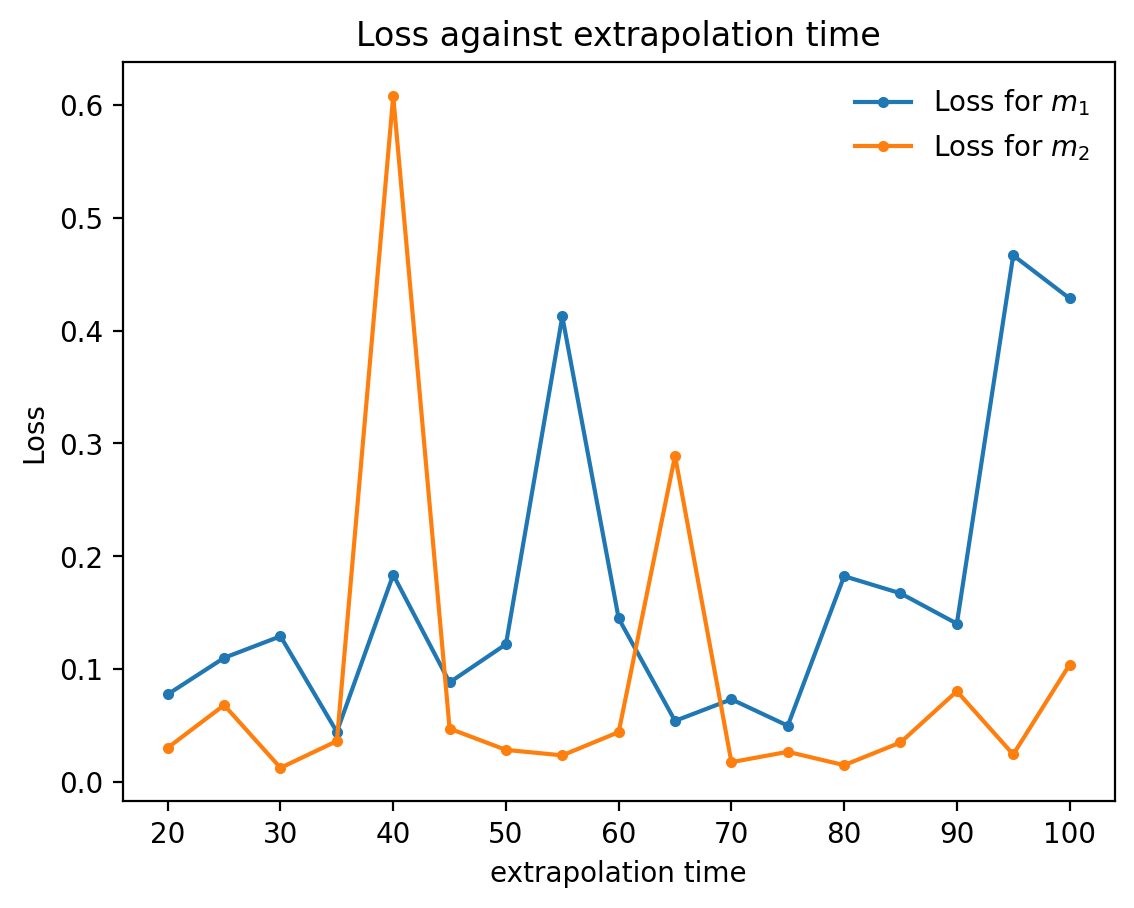

In [569]:
plt.figure()
plt.plot(np.arange(20,101,5), test_loss1Array, '.-',label=f"Loss for $m_1$")
plt.plot(np.arange(20,101,5), test_loss2Array, '.-',label=f"Loss for $m_2$")
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.legend()
plt.show()

> In general, $m_2$ shows better predicition performance than $m_1$, with $m_1$ also showing a stronger trend of decrease in performance as extrapolation time is increased

#### Now,(FINALLY), we run everything we have done in Part 5, but with more chaotic initial conditions of $z_0=[\pi/2,0,\pi/2,0]$

#### Let's set the initial condtions, calculate the required values and plot a graph of the Double-Pendulum.

(4, 501)


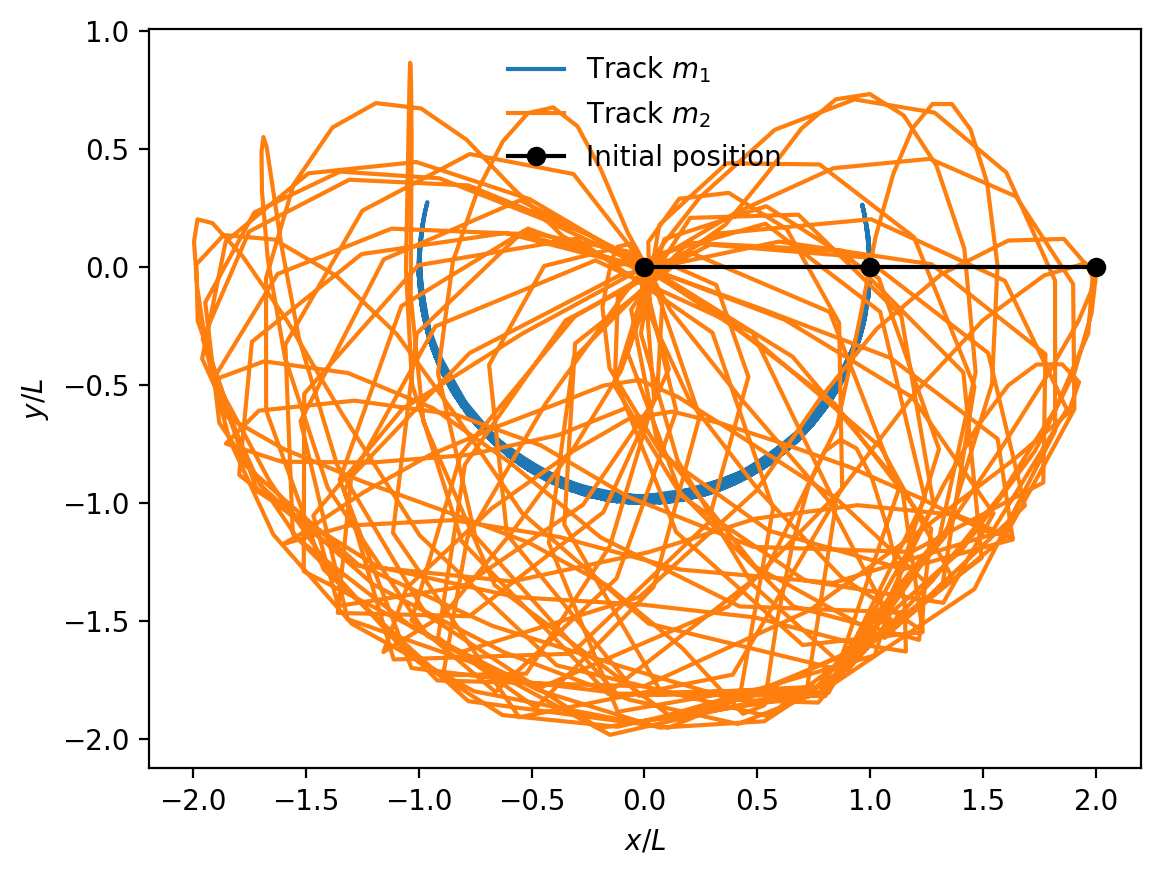

In [570]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()


#### Let's generate a new model, a new dataset for training and testing, and train the network on this dataset.

In [572]:
##Generating the model##
model = model2()

##Generating the datasets##
#We train the RNN over a limited range of the y data and x data and test it over the full range:

#Doing this for y-dataset.
y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]


#Generating the m1 and m2 test-data SEPARATELY
test_data1 = np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#Generating the training data based on m2
train_data = np.column_stack((x2_train, y2_train)).T


windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


#trainng and test dataset(inp=input and tgt=target for NN):
train_inp, train_tgt = create_dataset(train_data,offset, windowsize)
test_inp1, test_tgt1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_tgt2 = create_dataset(test_data2,offset, windowsize)


steps=1000  #Number of training steps
costs=np.zeros(steps) #empty array for cost along each step


for i in tqdm(range(steps)):
    
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_tgt.reshape(train_tgt.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    
    #Train the network and store to 'costs' empty array so that we can look at change in cost over steps.
    costs[i]=model.train_on_batch(in_train, targ_train)

100%|██████████| 1000/1000 [00:42<00:00, 23.65it/s]


#### Now, let's check how the cost varies with each step and how accurate the model's predictions are.

0.003365977667272091

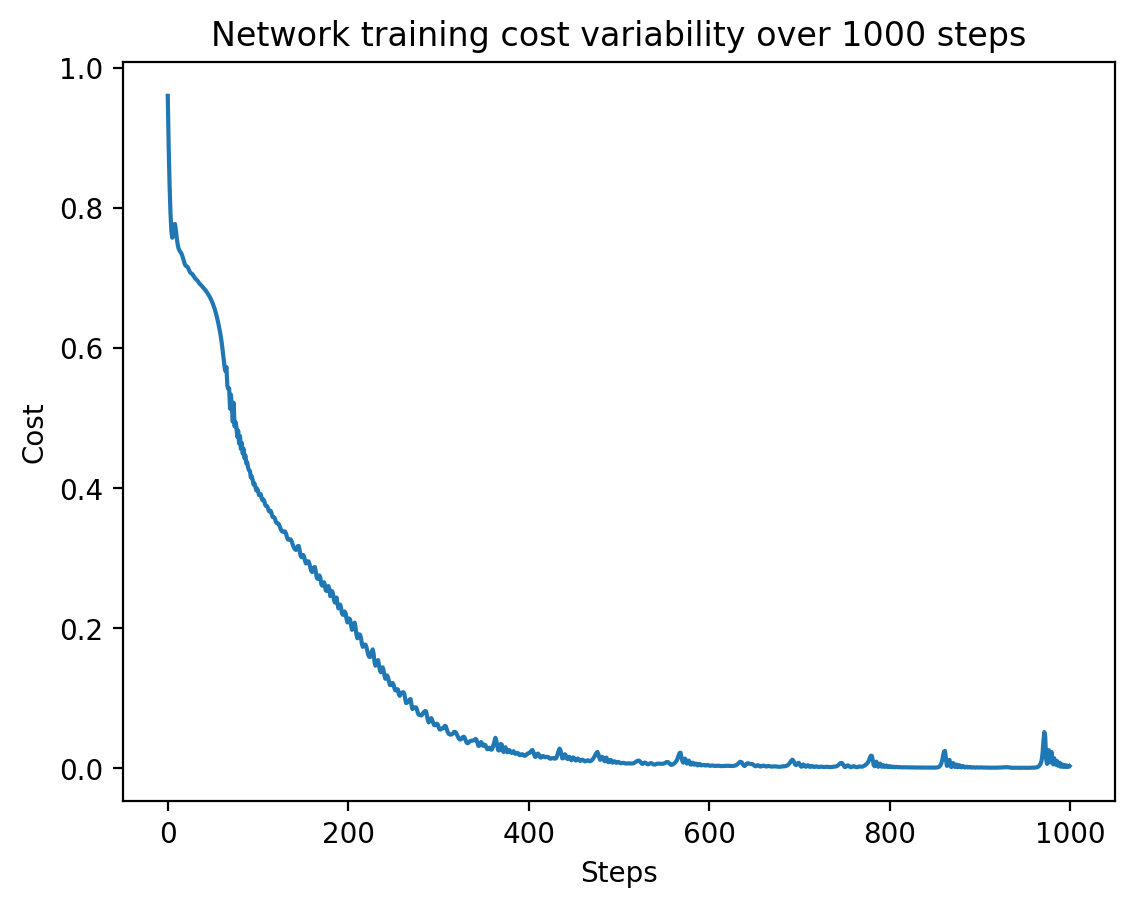

In [573]:
               ##How the cost varies with each step##
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network training cost variability over 1000 steps")
costs[-1]

> Here, we can see that the graph takes twice as many steps as the less chaotic initial conditions to stabilize.

#### Now, let's check the accuracy of our model's predictions.

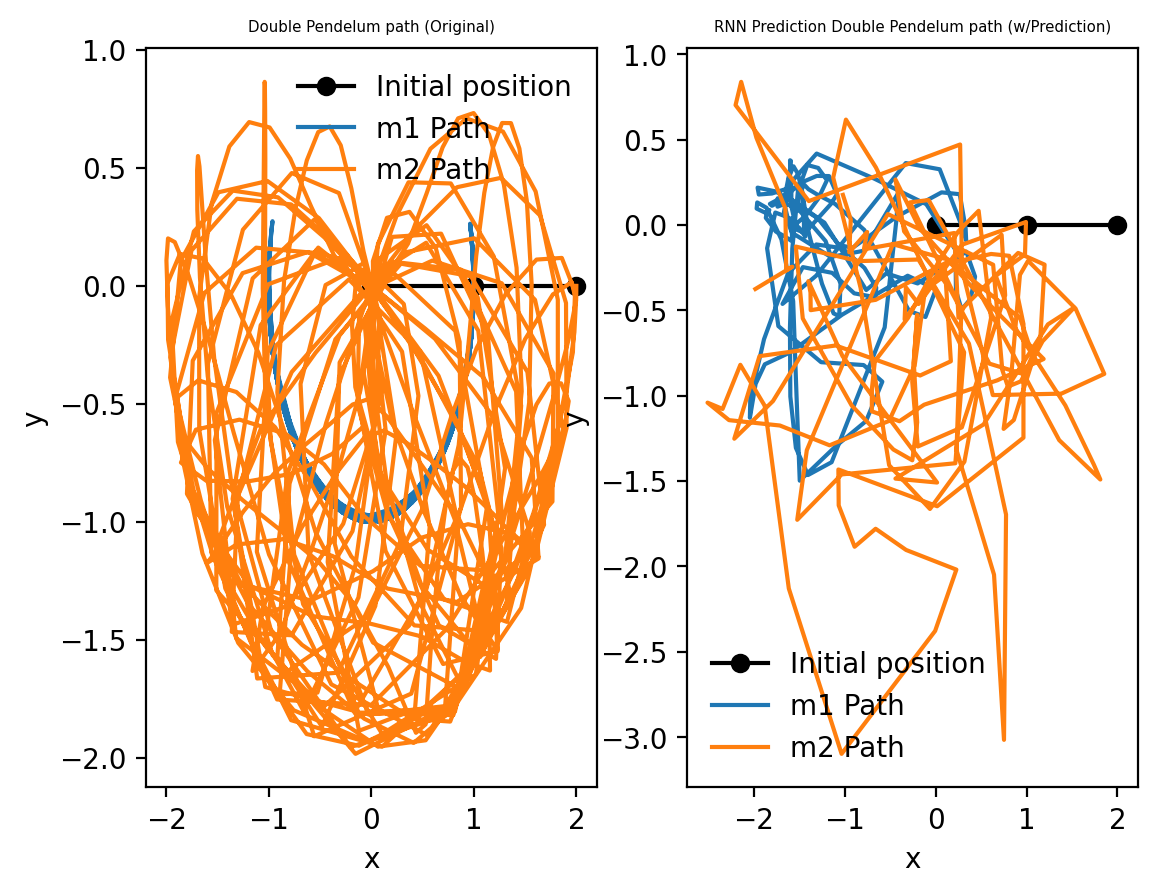

In [574]:
#Reshaping the test input data for the same reasons we did for the training input data before training the RNN
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=model.predict_on_batch(in_test1) #gives output from RNN
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=model.predict_on_batch(in_test2) #gives output from RNN


fig,ax=plt.subplots(nrows=1, ncols=2, )

#Plot for original double-pendulum movement:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path (Original)", size=5.4)
ax[0].legend()

#Plot of double-pendulum from prediction of RNN:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path (w/Prediction)", size=5.4)
ax[1].legend()

> Here, the model faces a lot of challeneges, including only predicting based on $m_2$ and being trained on chaotic conditions, thus, this bad predicrion is expected.

#### Now, let's check the stability of this network to variations in initial conditions without retraining the network.

#### For initial conditions: $z_0=[\pi/4,0,\pi/4,0]$. 
Varying the $\theta$-values

(4, 501)


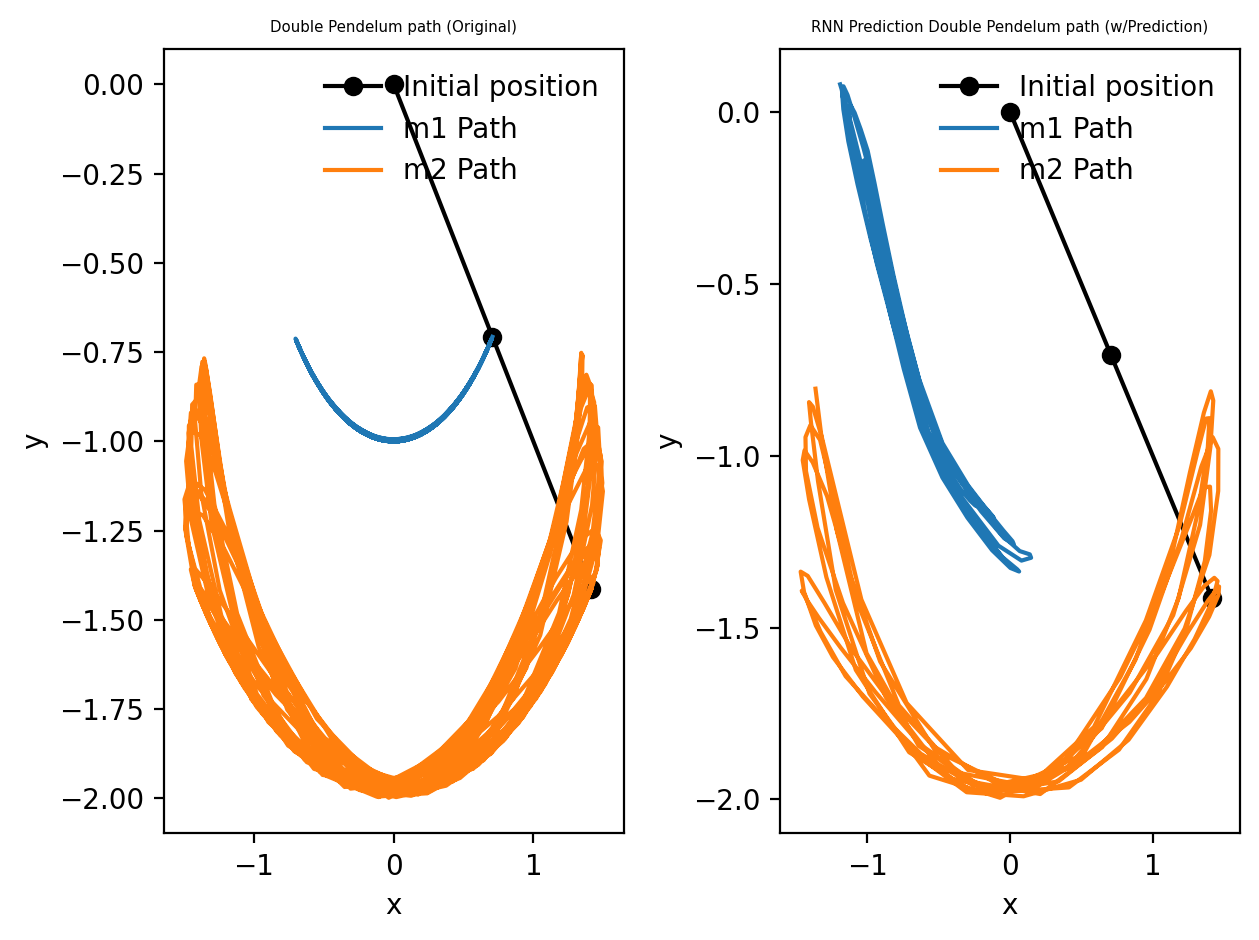

In [577]:
x1,x2,y1,y2 = variation_checker2(i=4,j=0)

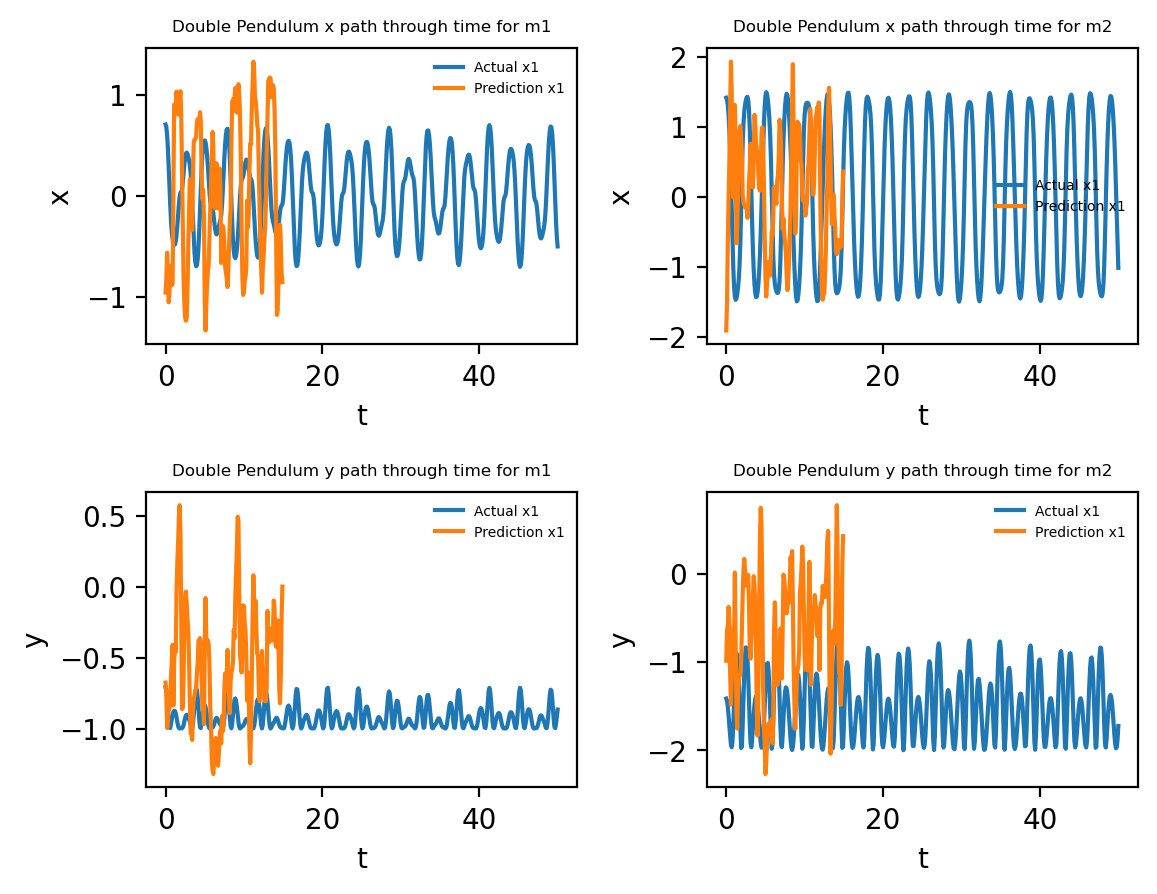

In [578]:
txy_plotter2()

#### For initial conditions: $z_0=[\pi/2,1,\pi/2,1]$.
Varying the $\omega$-values

(4, 501)


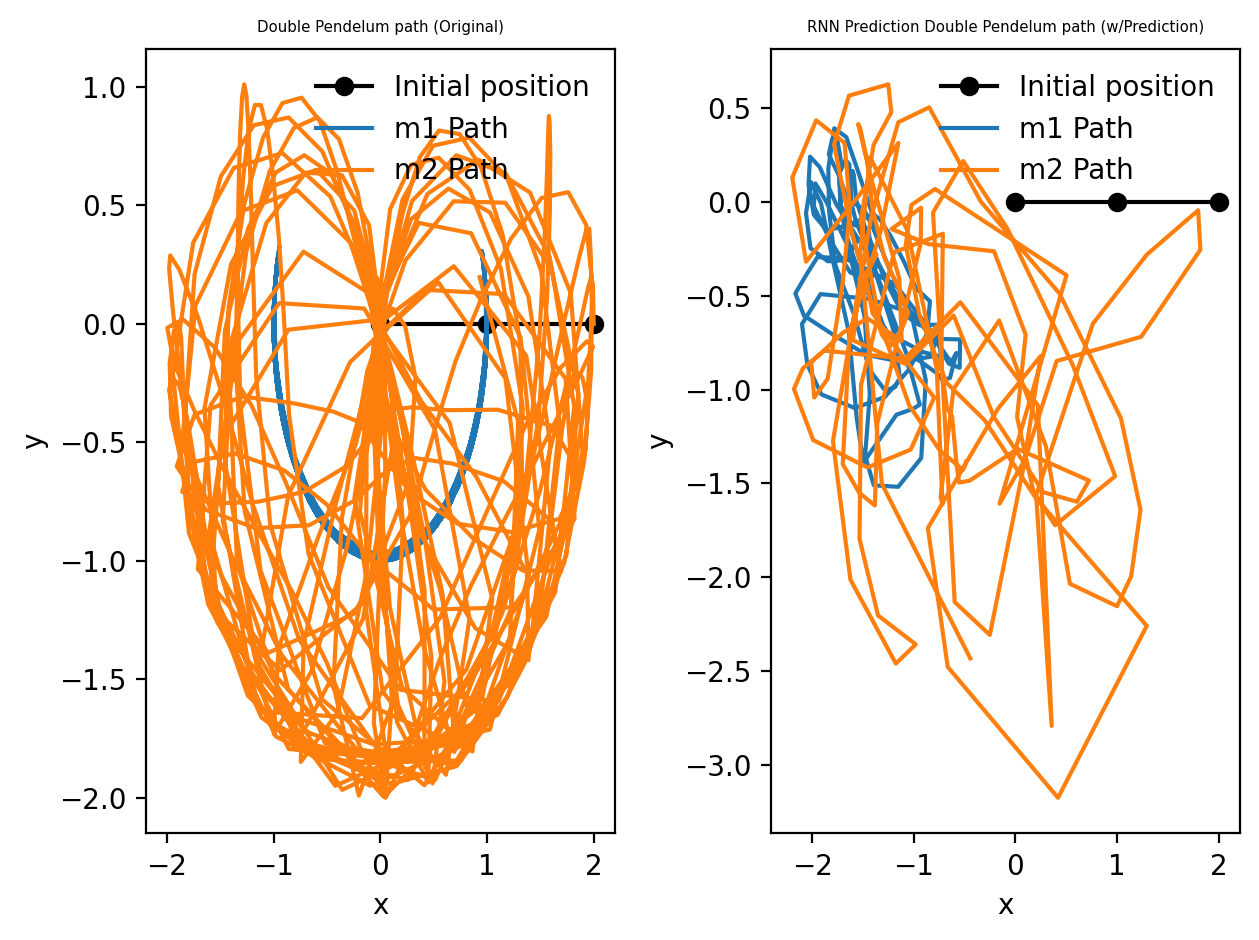

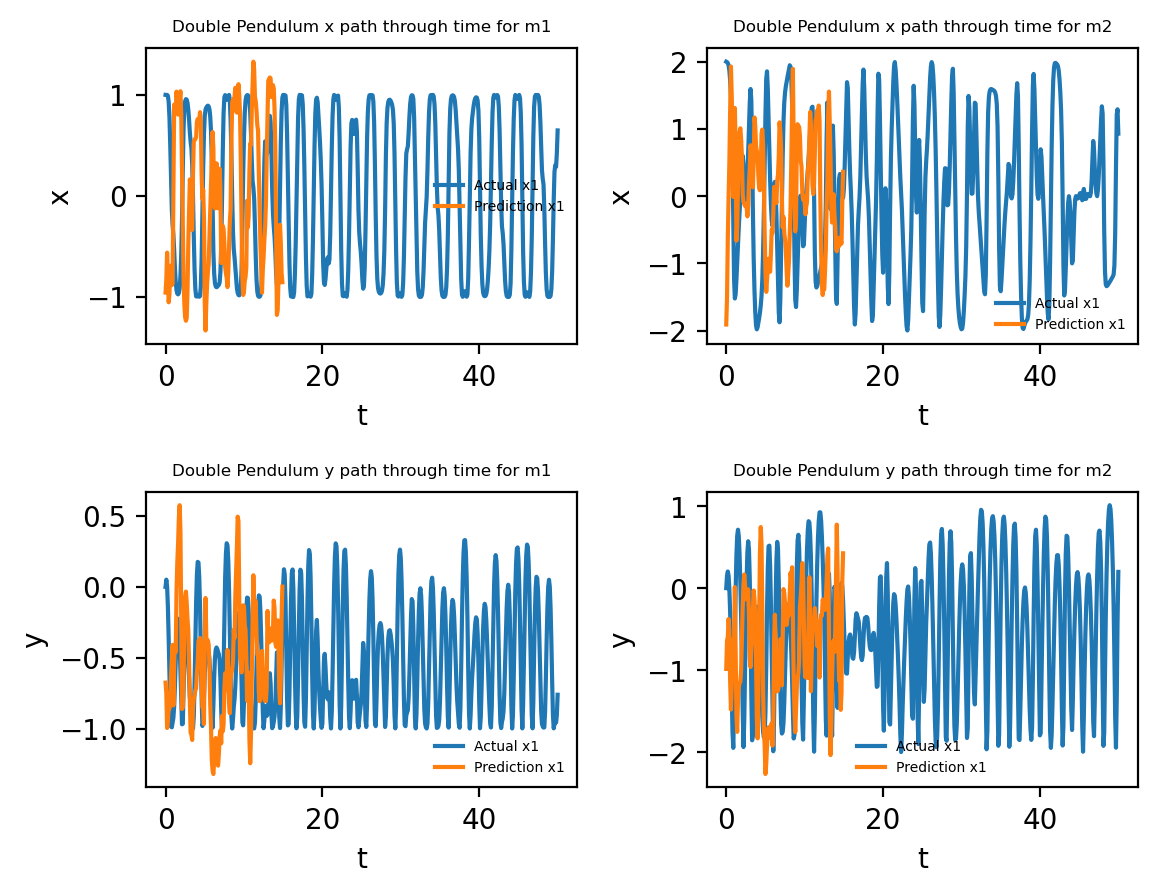

In [580]:
x1,x2,y1,y2 = variation_checker2(i=2,j=1,model=model)
txy_plotter2()

#### For initial conditions: $z_0=[\pi/4,2,\pi/4,2]$.
Varying both.

(4, 501)


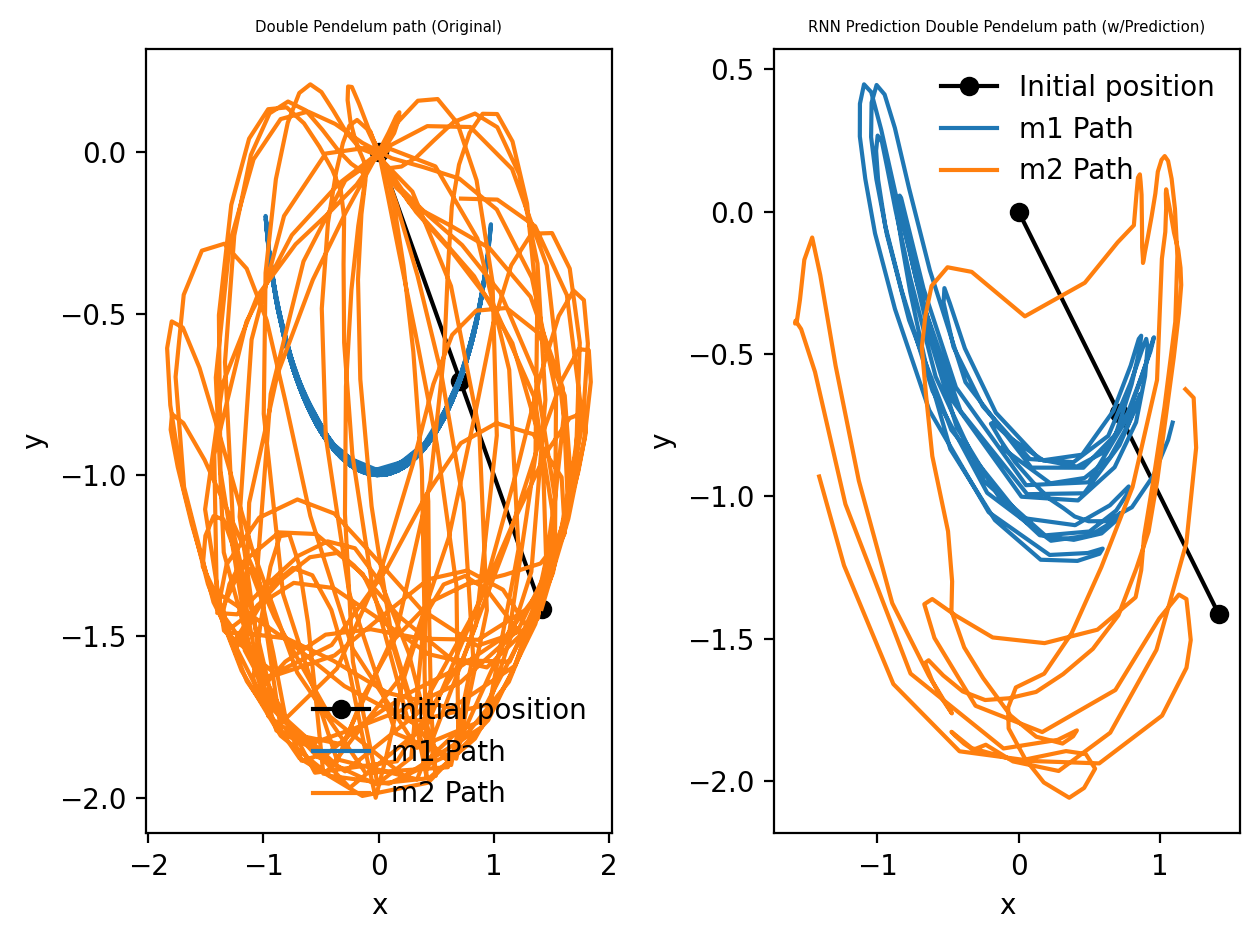

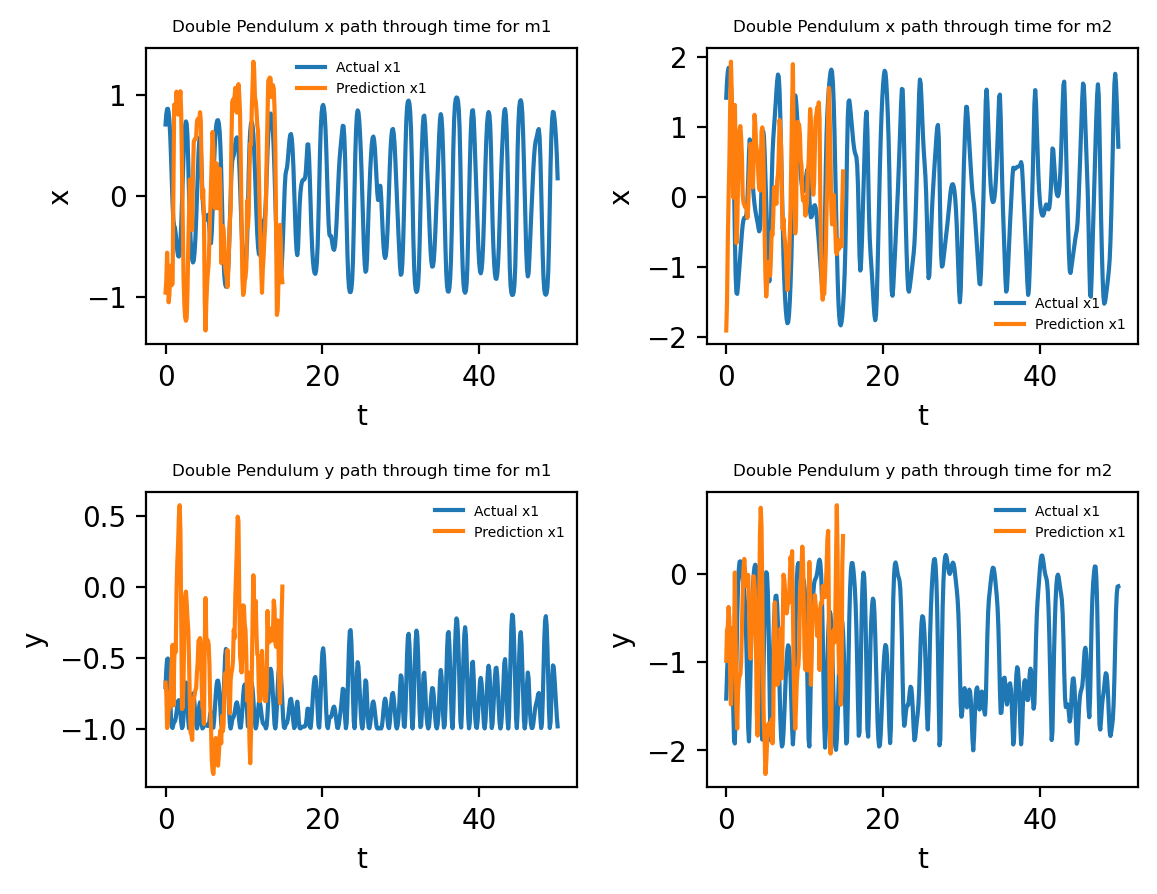

In [582]:
x1,x2,y1,y2 = variation_checker2(i=4,j=2)
txy_plotter2()

> Looking at the results from varying $\theta$ and $\omega$, we can see that this model deals poorly with variation in initial conditions. Here, we see a general trend of the predictions being a lot more chaotic than the actual movements, which is an expected result as the model expects very chaotic data to be fed in.

#### Now, let's see how far into the future the model (with Part-4's initial conditions) can predict well.

In [583]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

                    ###############################################################
                    ##Creating the training and testing datasets (same as before)##
                    ###############################################################

#Doing this for y-dataset.
y1_train=y1[0:int(0.6*len(y1))] #y1 training data will be on first 60% of the full data
y2_train=y2[0:int(0.6*len(y2))] #y2 training data will be on first 60% of the full data
y1_test=y1[int(0.6*len(y1)):-1] #y1 test data will be over the the last 40% of data
y2_test=y2[int(0.6*len(y2)):-1] #y2 test data will be over the the last 40% of data


#And now the same as above, but for x
x1_train=x1[0:int(0.6*len(x1))] 
x2_train=x2[0:int(0.6*len(x2))] 
x1_test=x1[int(0.6*len(x1)):-1]
x2_test=x2[int(0.6*len(x2)):-1]

#Generating the m1 and m2 test-data SEPARATELY
test_data1 = np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#Generating the training data based on m2
train_data = np.column_stack((x2_train, y2_train)).T

(4, 501)


In [584]:
modelArray = []

for i in range(17):
    modelgen = model2()
    modelArray.append(modelgen)

In [585]:
#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]
inp_tst1ARRAY =[]
trgt_tst1ARRAY=[]
inp_tst2ARRAY =[]
trgt_tst2ARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,5):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    test_inp1, test_lbl1 = create_dataset(test_data1,i, windowsize)
    test_inp2, test_lbl2 = create_dataset(test_data2,i, windowsize)
    
    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1])
    targ_test1 = test_lbl1.reshape(test_lbl1.shape[0], test_lbl1.shape[1])
    in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1])
    targ_test2 = test_lbl2.reshape(test_lbl2.shape[0], test_lbl2.shape[1])    
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    inp_tst1ARRAY.append(in_test1)
    trgt_tst1ARRAY.append(targ_test1)    
    inp_tst2ARRAY.append(in_test2)
    trgt_tst2ARRAY.append(targ_test2)    

In [586]:
test_loss1Array = []
test_loss2Array = []

for i in range(17):
    
    modelM = modelArray[i]
    historyM = modelM.fit(inp_trnARRAY[i], trgt_trnARRAY[i], epochs=30, verbose=0)
    test_lossN1 = modelM.evaluate(inp_tst1ARRAY[i], trgt_tst1ARRAY[i] , verbose=1)
    test_lossN2 = modelM.evaluate(inp_tst2ARRAY[i], trgt_tst2ARRAY[i] , verbose=1)
    
    test_loss1Array.append(test_lossN1)
    test_loss2Array.append(test_lossN2)

3/3 [==============================] - 0s 7ms/step - loss: 0.8316


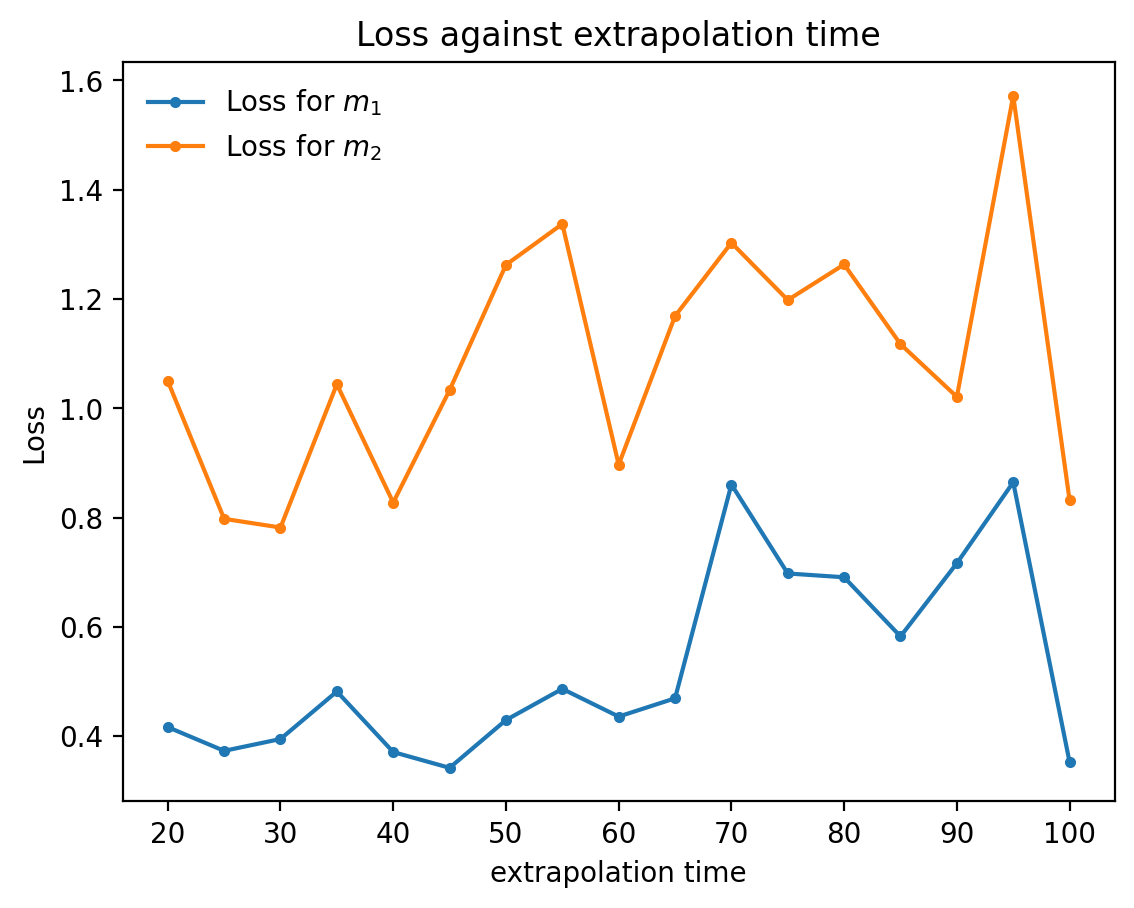

In [587]:
plt.figure()
plt.plot(np.arange(20,101,5), test_loss1Array, '.-',label=f"Loss for $m_1$")
plt.plot(np.arange(20,101,5), test_loss2Array, '.-',label=f"Loss for $m_2$")
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.legend()
plt.show()

> Here, due to how chaotic the initial condtitons are, the model is again able to predict m1 with better accuracy than m2 due to the changes not affecting m1's predicitions as the model has no info on m1. But it does have the ability to actually properly predict m2, which leads to worse loss scores here as the initial conditions do have an effect on the end product.